In [1]:
#Imports
import os, sys, gc
os.environ['OMP_NUM_THREADS'] = '3' #limits number of threads used (like by hp.smoothing)
import numpy as np
import scipy as sp 
import astropy as ap #Could only import SkyCoords or whatever else I use
import iminuit
import healpy as hp
import histlite as hl
from csky.utils import ensure_dir

from glob import glob

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<I3Frame> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::python::indexed_property_impl<double (I3DOMCalibration::*)(unsigned int) const, boost::mpl::vector3<double, I3DOMCalibration&, unsigned int>, void (I3DOMCalibration::*)(unsigned int, double), boost::mpl::vector4<void, I3DOMCalibration&, unsigned int, double> >::Proxy already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::map<OMKey, I3DOMCalibration, std::less<OMKey>, std::allocator<std::pair<OMKey const, I3DOMCalibration> > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::map<OMKey, I3DOMCalibration, std::less<OMKey>, std::allocator<std::pair<OMKey 

In [16]:
class BinnedTemplateAnalysis:
    """For conducting binned calculations using maximum likelihood statistical methods. 
    For binned sky map of IceCube event data, specifically for template analyses.
    
    (Now with energy!)
    
    
    """
    def __init__(self, data, sig, grl, is_binned=False, savedir=None, name='BinnedTemplateAnalysis', 
                 template=None, gamma=2.7, cutoff=None, ebins=None,
                 nside=128, min_dec_deg=-80, max_dec_deg=80, qtot=True,
                 verbose=False, force=False):
        """BinnedTemplateAllSky constructor
        
        Args:
            data: Path to numpy array(s) (directory or single file) containing  dtype=[('run', '<i8'), 
                                                 ('event', '<i8'),
                                                 ('subevent', '<i8'),
                                                 ('ra', '<f8'),
                                                 ('dec', '<f8'),
                                                 ('azi', '<f8'),
                                                 ('zen', '<f8'),
                                                 ('time', '<f8'),
                                                 ('logE', '<f8'),
                                                 ##('angErr', '<f8')])
                                                 
                OR: Path to numpy array of binned data (in this case, set is_binned=True)
                                     
            sig: Path to numpy array containing  dtype = [('run', int), 
                                                 ('event', int), 
                                                 ('subevent', int),
                                                 ('ra', float), 
                                                 ('dec', float),
                                                 ('true_ra', float), 
                                                 ('true_dec', float),
                                                 ('azi', float), 
                                                 ('zen', float), 
                                                 ('time', float),
                                                 ('logE', float), 
                                                 ('true_angErr', float), 
                                                 ('oneweight', float),     
                                                 ('true_energy', float)]
            
            grl: Path to numpy array with GRL runs
                                     
            is_binned: boolean, True if argument data is an array of binned_data, otherwise False (data will be binned)
            
            savedir: path to directory to save binned data. Default: None (don't save)
            
            name: unique name to identify analysis (used in file names when saving)
            
            template: path to template array or None
                TO DO:
                    * Rescale template nside for differing energy ranges?
                                                            
            gamma: spectral index for detector acceptance and injections. 
                    
            cutoff: minimum template value to be considered an On bin
                TO DO (???):
                    * Implementation without need for cutoff???
                    
            ebins: Choice of log10(energy) bins. If None, use default (hardcoded) bins. If a single integer,
                use `ebins` evenly spaced bins in log10(energy). If a list of numbers, assumed to be 
                log10(energy) bin edges. If `is_binned` is True, `ebins` will be determined from the loaded data.

            nside: integer for healpy nside (Default: 128)
                TO DO: 
                    * Allow nside to differ for different energy ranges?
                        
            min_/max_dec_deg: min and max declination in degrees for likelihood calculations.
            
            qtot: If True, use total charge instead of reconstructed energy for "energy" binning of events
            
            verbose: True for lots of output (Default: False)
            
            force: boolean, if `is_binned` is True and the loaded data does not match the provided `nside`, set this
                to True to resize the loaded, binned data to the give nside. If False, will raise ValueError (Default: False)
            
            
        """
        if template is None:
            raise NotImplementedError('Current implementation can only perform template analysis!')
        elif cutoff is None:
            raise NotImplementedError('Current implementation requires a cutoff to define on/off bins!')
        
        print('Setting up:')
        
        self.name = name
        self.savedir = savedir
        ensure_dir(savedir)
        
        self.verbose = verbose
        
        self.gamma = gamma
        self.cutoff = cutoff
        self.nside = nside
        self.min_dec_deg = min_dec_deg
        self.max_dec_deg = max_dec_deg
        
        #sindec band edges: default here taken from PSTracks in csky
        self.sindec_bins = np.unique(np.concatenate([
                             np.linspace(-1, -0.93, 4 + 1),
                             np.linspace(-0.93, -0.3, 10 + 1),
                             np.linspace(-0.3, 0.05, 9 + 1),
                             np.linspace(0.05, 1, 18 + 1) ]) )
        
        #Load GRL which should be in format of an array of (good) run numbers
        self.grl = np.load(grl)
        
        #Load signal events and calculate relative weights
        self.sig_evs = np.load(sig)
        print(f'Loaded signal array <-- {sig}')        
        self.sig_relweights = self.sig_evs['oneweight'] * self.sig_evs['true_energy']**(-self.gamma)
        
        #If using total charge as proxy for energy...
        if qtot:
            if ('qtot' not in self.sig_evs.dtype.names):
                raise ValueError('QTot option is True, but signal array does not contain `qtot` field!')
            #If sig array contains qtot with DeepCore, use with DeepCore
            if 'qtot_wdc' in self.sig_evs.dtype.names:
                q_name = 'qtot_wdc'
            else:
                q_name = 'qtot'
            #Set the name for "log Energy" bins to logQtot
            self.logE_name = 'logQtot'
            
            #Add log10 of QTot to the sig array for consistency with logE by constructing new array
            new_dtype = np.dtype(self.sig_evs.dtype.descr + [(self.logE_name, '<f8')])
            new_arr = np.empty(self.sig_evs.shape, dtype=new_dtype)
            for n in self.sig_evs.dtype.names:
                new_arr[n] = self.sig_evs[n]
            new_arr[self.logE_name] = np.log10(self.sig_evs[q_name])

            #Reassign the sig array to be the new array (includes logQtot field) and clear up the temporary array
            self.sig_evs = new_arr.copy()            
            del new_arr
            
        #Otherwise, if just using energy and not qtot...
        else:
            self.logE_name = 'logE'
            
        #ebins is really logEbins. If None, assign some default value which depends on if using energy or qtot.
        #Should likely avoid default bins, or determine a good set of default bins.
        if (ebins is None) or ((len(ebins)==1) and (ebins[0]==0)):
            if not is_binned:
                print('Using default EBins.')
            #Default qtot bins were determined to have roughly equal number of events in 100 bins
            if qtot:
                self.logE_bins = np.array([1.5051, 1.5493, 1.5761, 1.5963, 1.6125, 1.6261, 1.6382, 1.6493,
                                           1.6592, 1.6686, 1.6774, 1.6855, 1.6935, 1.7011, 1.7084, 1.7154,
                                           1.7224, 1.729 , 1.7356, 1.7419, 1.7482, 1.7543, 1.7604, 1.7664,
                                           1.7723, 1.7782, 1.7839, 1.7896, 1.7954, 1.8009, 1.8065, 1.8119,
                                           1.8176, 1.823 , 1.8285, 1.8341, 1.8395, 1.8451, 1.8506, 1.8561,
                                           1.8615, 1.8672, 1.8727, 1.8782, 1.8839, 1.8896, 1.8953, 1.9012,
                                           1.907 , 1.9128, 1.9187, 1.9248, 1.9308, 1.937 , 1.9434, 1.9498,
                                           1.9563, 1.963 , 1.9696, 1.9768, 1.9839, 1.9912, 1.9988, 2.0065,
                                           2.0144, 2.0226, 2.0311, 2.04  , 2.0492, 2.0589, 2.0689, 2.0795,
                                           2.0906, 2.1023, 2.1149, 2.1283, 2.1427, 2.1581, 2.1749, 2.1931,
                                           2.2131, 2.2353, 2.2596, 2.287 , 2.3175, 2.3517, 2.3896, 2.4321,
                                           2.4794, 2.5323, 2.592 , 2.6584, 2.7228, 2.7804, 2.8347, 2.8891,
                                           2.9452, 3.0136, 3.1295])
            else:
                self.logE_bins = np.array([1.,2.,3.,4.,5.,6.,7.])

            self.n_logE_bins = len(self.logE_bins)+1
        #If ebins is 1
        elif (len(ebins)==1) and (ebins[0]==1):
            self.logE_bins = np.array([0.0, np.inf])
            self.n_logE_bins = 1
        #If ebins argument is one number, make evenly space bins
        elif (len(ebins) == 1):
            ebins = ebins[0]
            if not is_binned:
                print(f'Using {ebins} EBins.')
            
            if qtot:
                self.logE_bins = np.linspace(1.5, 3.5, ebins-1)
            else:
                self.logE_bins = np.linspace(1, 7, ebins-1)

            self.n_logE_bins = ebins
        #If ebins is more than one number, use those as the bin edges
        else: #len(ebins) > 1
            if not is_binned:
                print('Using user-defined EBins.')
            self.logE_bins = np.array(ebins) 
            self.n_logE_bins = len(self.logE_bins)+1

        #Load experimental data (and bin it if it is not already binned)
        if is_binned:
            #Binned data will be dictionary with {'logE_bins': array, 'binned_data': ndarray}
            binned_dict = np.load(data, allow_pickle=True)
            
            #Replace ebins with those from loaded binned data
            print('Using loaded EBins.')
            #self.logE_bins = binned_dict.item()['logE_bins']
            #Get binned data from dictionary
            #self.binned_data = binned_dict.item()['binned_data'] 
            #self.n_logE_bins = len(self.binned_data)

            self.logE_bins = np.array([0.0, binned_dict.item()['logE_bins'][0]])
            self.binned_data = binned_dict.item()['binned_data'][0].reshape((1,hp.nside2npix(self.nside)))
            self.n_logE_bins = 1
            
            #Check to see if binned_data nside matches that provided in argument, if not...
            if self.binned_data.shape[1] != hp.nside2npix(self.nside):
                #...and if force is True, resize the binned data.
                if force:
                    print(f"*** Re-sizing binned data with Nside={hp.npix2nside(self.binned_data.shape[1])} to {self.nside}! ***")
                    self.binned_data = hp.ud_grade(self.binned_data, self.nside)
                #Otherwise, if force is False, raise an error
                else:
                    raise ValueError(f"Nside of loaded binned data is {hp.npix2nside(self.binned_data.shape[1])}, but given nside is {self.nside}! \
                                     \n    You need to rebin your data or use force=True.")
            print(f'Load binned data <-- {data}')
            print(f'    Binned data loaded: Contains {self.binned_data.sum().sum()} total counts')
              
        else:
            #If the data is not already binned, load and bin it
            self.load(data)
            
        #Get logE bin indices for MC events
        if self.n_logE_bins > 1:
            sig_ebin_inds = np.digitize(self.sig_evs[self.logE_name], self.logE_bins)
        elif self.n_logE_bins == 1:
            sig_ebin_inds = np.zeros_like(self.sig_evs[self.logE_name], dtype=int)
        else:
            raise ValueError("Something is wrong with the number of energy bins!")
        
        #Get median angular error from truth in MC for each ebin (used for smoothing of template)
        #Also get signal acceptance fraction for use in TS and injections
        #Also bin the signal events which is used in PDF making
        med_sigs = np.zeros(self.n_logE_bins)
        self.sig_acc_frac = np.zeros(self.n_logE_bins)
        self.rel_binned_sig = np.zeros((self.n_logE_bins, hp.nside2npix(self.nside)))
        for e in range(self.n_logE_bins):
            #Mask events in this ebin
            e_mask = sig_ebin_inds == e
            #Get weighted median
            med_sigs[e] = self.weighted_quantile(self.sig_evs['true_angErr'][e_mask], self.sig_relweights[e_mask], 0.5)
            #Get fraction of expected signal events
            self.sig_acc_frac[e] = np.sum(self.sig_relweights[e_mask]) / np.sum(self.sig_relweights)
            #Get binned signal events (relative weights, not actual counts)
            self.rel_binned_sig[e] = self.bin_data(self.sig_evs[e_mask], verbose=False, sig=True, weights=self.sig_relweights[e_mask])
        
        #Get coordinates of pixels        
        self.bin_thetas, self.bin_phis = hp.pix2ang(self.nside, np.arange(hp.nside2npix(self.nside)))
        self.bin_ras = self.bin_phis
        self.bin_decs = np.pi/2.0 - self.bin_thetas
        
        #Get sinDec (relative) acceptances for signal
        #self.binned_sig_acc = self.get_binned_acc_from_median(self.rel_binned_sig, acc='signal')
        
        #Load template, create versions with acceptance and/or smoothing
        print(f'Load template <-- {template}')
        template = np.load(template, allow_pickle=True)         
        self.template = template.copy()
        self.create_template_pdf(med_sigs)
        
        #Get sinDec (relative) acceptances for bg
        #self.binned_bg_acc = self.get_binned_acc_from_median(self.binned_data, acc='bg')
        
        #Get S and B PDFs for likelihood (properly normalized, I hope)
        #self.create_bg_acc_without_sindec()
        self.get_pdfs()

        print('***Setup complete!*** \n')
        
    def weighted_quantile(self, data, weights, quantile):
        #Used mostly for getting weighted medians (quantile = .5)
        ix = np.argsort(data)
        data = data[ix] # sort data
        weights = weights[ix] # sort weights
        csw = np.cumsum(weights)
        cut = np.sum(weights) * quantile
        if len(data) == 0:
            q = 0.0
        else:
            q = data[csw >= cut][0]
        return q
        
    def bin_data(self, data, verbose=None, sig=False, weights=None):
        """
        Convert event data into bin counts using healpy. 
        
        Args:
            data: data event array(s)
            
            verbose: True to show more output (Defaults to class's initited value)
            
            sig: Boolean, True if binning signal (using true locations and weights). False (default) for data which uses reco locations.
            
            weights: Array of weights to use when sig=True (Default: None).
            
        """
        
        if verbose is None:
            verbose = self.verbose
        
        #Get dec and ra of events
        if sig:
            event_decs = data['true_dec']
            event_ras = data['true_ra']
        else:
            event_decs = data['dec']
            event_ras = data['ra']
        
        if verbose:
            print(f'Binning {len(event_ras)} events with nside={self.nside} ', end=' ')
        
        #Get pixel number for each event
        event_pix_nums = hp.ang2pix(self.nside, np.pi/2.0 - event_decs, event_ras)
        
        if verbose:
            print('--> Binning Done.')
        
        #Return the count for each pixel
        #minlength ensures the output array is the proper length even if there are pixels with zero counts on the end
        if sig:
            return np.bincount(event_pix_nums, minlength=hp.nside2npix(self.nside), weights=weights)
        else:
            return np.bincount(event_pix_nums, minlength=hp.nside2npix(self.nside))
    
    def load(self, path, verbose=None):
        """
        Loads data and bins it.
        
        Args:
            path: path to directory containing data files or path to a data file
            
            verbose: True to show more output (Defaults to class's initited value)
            
        """
        if verbose is None:
            verbose = self.verbose
        #Make sure path is a directory or a file
        assert (os.path.isdir(path) or os.path.isfile(path)), f"Expected path to directory or file, got: {path}"
        
        print(f'Loading and binning data from {path}')
        if os.path.isdir(path):
            #If path is a directory, make list of numpy files from that directory
            files_like = path+'/*.npy'
            file_list = sorted(glob(files_like))
            
        else: #path is one file
            #If just one file, make it into a list
            file_list = [path]
            
        self.binned_data = np.zeros((self.n_logE_bins, hp.nside2npix(self.nside)))
        #Loop through files    
        for file in file_list:
            #Load the data
            data = np.load(file)
            #If using qtot instead of energy, add the logQtot field to the data array (just like for MC above)
            if self.logE_name == 'logQtot':
                if 'qtot_wdc' in data.dtype.names:
                    q_name = 'qtot_wdc'
                else:
                    q_name = 'qtot'
                    
                #If binning data, make the same addition of logQtot field to the data array
                #Add log10 of QTot to the sig array for consistency with logE
                new_dtype = np.dtype(data.dtype.descr + [(self.logE_name, '<f8')])
                new_arr = np.empty(data.shape, dtype=new_dtype)
                for n in data.dtype.names:
                    new_arr[n] = data[n]
                new_arr[self.logE_name] = np.log10(data[q_name])

                data = new_arr.copy()
            
            #Mask events from GRL
            mask = np.isin(data['run'], self.grl)
            data = data[mask]
            
            #Get logE bin indices for each event (if only one bin, all zeros)
            if self.n_logE_bins > 1:
                e_inds = np.digitize(data[self.logE_name], self.logE_bins)
            elif self.n_logE_bins == 1:
                e_inds = np.zeros_like(data[self.logE_name], dtype=int)
            else:
                raise ValueError("Something is wrong with the number of energy bins!")

            if verbose:
                print(f'    {file} : ')
            
            #Loop through unique energy bin indices
            for e in np.unique(e_inds):
                if verbose:
                    print(f'        Energy Bin {e+1}/{self.n_logE_bins}...', end=' ')
                #Mask events in this energy bin
                e_mask = (e_inds == e)
                #bin the events from this file and add to the binned_data (initialized above as all zeros)
                self.binned_data[e] = self.binned_data[e] + self.bin_data(data[e_mask])
                
                if verbose:
                    print(' --> Done.')
        
        #Free up memory
        del new_arr
        del data
        gc.collect()
        
        print('--> Data Loading Done. \n')
        
        #If loading and binning data, and if savedir is given, save
        if self.savedir is not None:
            binned_dict = {'logE_bins': self.logE_bins,
                           'binned_data': self.binned_data}
            savefile = f'{self.savedir}/{self.name}.binned_data.nside{self.nside}.npy'
            i = 0
            #if save file already exists, append a number to the file name
            if os.path.exists(savefile):
                print('Saved file of chosen name already exists!')
                while os.path.exists(savefile):
                    savefile = f'{self.savedir}/{self.name}.binned_data_{i}.nside{self.nside}.npy'
                    i += 1
            np.save(savefile, binned_dict)
            print(f'Binned data saved to --> {savefile}')
            
        return

    def create_bghists(self, path, savedir=None):
        """
        testing
        """
        if savedir is None:
            savedir = self.savedir
        ensure_dir(savedir)
        
        if os.path.isdir(path):
            #If path is a directory, make list of numpy files from that directory
            files_like = path+'/*.npy'
            file_list = sorted(glob(files_like))
            
        else: #path is one file
            #If just one file, make it into a list
            file_list = [path]

        #Loop through files    
        bg_hists = np.empty(self.n_logE_bins, dtype=object)
        for file in file_list:
            f_ind = 0
            #Load the data
            data = np.load(file)
            #If using qtot instead of energy, add the logQtot field to the data array (just like for MC above)
            if self.logE_name == 'logQtot':
                if 'qtot_wdc' in data.dtype.names:
                    q_name = 'qtot_wdc'
                else:
                    q_name = 'qtot'
                    
                #If binning data, make the same addition of logQtot field to the data array
                #Add log10 of QTot to the sig array for consistency with logE
                new_dtype = np.dtype(data.dtype.descr + [(self.logE_name, '<f8')])
                new_arr = np.empty(data.shape, dtype=new_dtype)
                for n in data.dtype.names:
                    new_arr[n] = data[n]
                new_arr[self.logE_name] = np.log10(data[q_name])

                data = new_arr.copy()

            #Mask events from GRL
            mask = np.isin(data['run'], self.grl)
            data = data[mask]
            
            #Get logE bin indices for each event (if only one bin, all zeros)
            if self.n_logE_bins > 1:
                e_inds = np.digitize(data[self.logE_name], self.logE_bins)
            elif self.n_logE_bins == 1:
                e_inds = np.zeros_like(data[self.logE_name], dtype=int)
            else:
                raise ValueError("Something is wrong with the number of energy bins!")
            
            #Loop through unique energy bin indices
            for e in np.unique(e_inds):
                #Mask events in this energy bin
                e_mask = (e_inds == e)
                h = hl.hist(np.sin(data['dec']), bins=np.linspace(-1,1,50))
                if f_ind==0:
                    bg_hists[e] = bg_hists[e]
                else:
                    bg_hists[e] = bg_hists[e] + h
                    
        f_ind += 1
        #Free up memory
        del new_arr
        del data
        gc.collect()
        
        #If loading and binning data, and if savedir is given, save
        if savedir is not None:
            binned_dict = {'logE_bins': self.logE_bins,
                           'hists': bg_hists}
            savefile = f'{savedir}/{self.name}.bg_hists.npy'
            i = 0
            #if save file already exists, append a number to the file name
            if os.path.exists(savefile):
                print('Saved file of chosen name already exists!')
                while os.path.exists(savefile):
                    savefile = f'{savedir}/{self.name}.bg_hists_{i}.npy'
                    i += 1
            np.save(savefile, binned_dict)
            print(f'BG Hists saved to --> {savefile}')
            
        return        

    def create_scramble(self, path, verbose=None, seed=0, savedir=None):
        """
        Loads data, scrambles it, and bins it.
        
        Args:
            path: path to directory containing data files or path to a data file
            
            verbose: True to show more output (Defaults to class's initited value)

            seed: For RNG in scrambling.

            savedir: directory to save binned scrambles (Default: None, which sets to self.savedir)
            
        """
        if verbose is None:
            verbose = self.verbose
        if savedir is None:
            savedir = self.savedir
        ensure_dir(savedir)
        #Make sure path is a directory or a file
        assert (os.path.isdir(path) or os.path.isfile(path)), f"Expected path to directory or file, got: {path}"
        
        print(f'Loading, scrambling, and binning data from {path}')
        if os.path.isdir(path):
            #If path is a directory, make list of numpy files from that directory
            files_like = path+'/*.npy'
            file_list = sorted(glob(files_like))
            
        else: #path is one file
            #If just one file, make it into a list
            file_list = [path]
            
        ra_rng = np.random.default_rng(seed=seed)
        binned_scramble = np.zeros((self.n_logE_bins, hp.nside2npix(self.nside)))
        #Loop through files    
        for file in file_list:
            #Load the data
            data = np.load(file)
            #If using qtot instead of energy, add the logQtot field to the data array (just like for MC above)
            if self.logE_name == 'logQtot':
                if 'qtot_wdc' in data.dtype.names:
                    q_name = 'qtot_wdc'
                else:
                    q_name = 'qtot'
                    
                #If binning data, make the same addition of logQtot field to the data array
                #Add log10 of QTot to the sig array for consistency with logE
                new_dtype = np.dtype(data.dtype.descr + [(self.logE_name, '<f8')])
                new_arr = np.empty(data.shape, dtype=new_dtype)
                for n in data.dtype.names:
                    new_arr[n] = data[n]
                new_arr[self.logE_name] = np.log10(data[q_name])

                data = new_arr.copy()
            
            #Mask events from GRL
            mask = np.isin(data['run'], self.grl)
            data = data[mask]

            #Randomize RAs
            data['ra'] = ra_rng.random(size=len(data['ra'])) * 2.0 * np.pi
            
            #Get logE bin indices for each event (if only one bin, all zeros)
            if self.n_logE_bins > 1:
                e_inds = np.digitize(data[self.logE_name], self.logE_bins)
            elif self.n_logE_bins == 1:
                e_inds = np.zeros_like(data[self.logE_name], dtype=int)
            else:
                raise ValueError("Something is wrong with the number of energy bins!")

            if verbose:
                print(f'    {file} : ')
            
            #Loop through unique energy bin indices
            for e in np.unique(e_inds):
                if verbose:
                    print(f'        Energy Bin {e+1}/{self.n_logE_bins}...', end=' ')
                #Mask events in this energy bin
                e_mask = (e_inds == e)
                #bin the events from this file and add to the binned_data (initialized above as all zeros)
                binned_scramble[e] = binned_scramble[e] + self.bin_data(data[e_mask])
                
                if verbose:
                    print(' --> Done.')
        
        #Free up memory
        del new_arr
        del data
        gc.collect()
        
        print('--> Data Loading Done. \n')
        
        #If loading and binning data, and if savedir is given, save
        if savedir is not None:
            binned_dict = {'logE_bins': self.logE_bins,
                           'binned_scramble': binned_scramble}
            savefile = f'{savedir}/{self.name}.binned_scramble.seed{seed}.nside{self.nside}.npy'
            i = 0
            #if save file already exists, append a number to the file name
            if os.path.exists(savefile):
                print('Saved file of chosen name already exists!')
                while os.path.exists(savefile):
                    savefile = f'{savedir}/{self.name}.binned_scramble_{i}.seed{seed}.nside{self.nside}.npy'
                    i += 1
            np.save(savefile, binned_dict)
            print(f'Binned scramble saved to --> {savefile}')
            
        return
    
    def create_bg_acc_spline(self, skw={}):
        """
        Create detector acceptance spline (*background*, sinDec-dependent).
        
        Pieces taken from csky.
        
        TO DO: Is this right?
        
        Args:          
            skw: histlite.Hist.spline_fit kwargs
        
        Returns: histlite spline object
        
        """
        #Spline Params
        skw.setdefault('s', 0) #smooth
        skw.setdefault('k', 2) #spline degree
        skw.setdefault('log', True) #fit to log values
        
        #Determine dec bands for pdf:
        #This is really just the declination rows of pixels, but avoiding rows with no background pixels near the poles
        start = 0
        stop = len(np.unique(self.bin_decs))-1
        for e in range(self.n_logE_bins):
            mask = (self.template_acc_smoothed[e] <= self.cutoff)
            num_bg_pix_per_dec = np.array([np.sum(mask & (self.bin_decs==d)) for d in np.unique(self.bin_decs)])
            start = np.maximum(start, np.nonzero(num_bg_pix_per_dec)[0][0])
            stop = np.minimum(stop, np.nonzero(num_bg_pix_per_dec)[0][-1])

        #Get edges of dec bands for selecting pixels below
        #bin_edges = np.arcsin(self.sindec_bins)
        bin_edges = np.unique(self.bin_decs)[:-1] + np.diff(np.unique(self.bin_decs))/2
        bin_edges = np.r_[-np.pi/2, bin_edges[start:stop], np.pi/2]
    
        bg_acc_spline = np.empty(self.n_logE_bins, dtype=object)
        bg_hist = np.empty(self.n_logE_bins, dtype=object)
        #loop through ebins
        #for e in range(self.n_logE_bins):
        for e in range(self.n_logE_bins):

            #BG pdf using only "off" pixels as defined by cutoff
            mask = (self.template_acc_smoothed[e] <= self.cutoff)

            dOmega_corr = []
            dec_npix = []
            for i in np.arange(len(bin_edges)-1):
            #for d in np.unique(self.bin_decs):
                #Get pixel numbers from band of sindec
                pixels_in_band = hp.query_strip(self.nside, np.pi/2-bin_edges[i+1], np.pi/2-bin_edges[i])
                #Get boolean array: True if pixel from this sindec band is in signal region
                bool_array = np.isin(pixels_in_band, np.arange(hp.nside2npix(self.nside))[~mask])
                #Count number of signal pixels in this sindec band
                number_true = np.count_nonzero(bool_array)
                #Get correction factor: number of pixels in band / number of bg pixels in band
                corr = float(len(pixels_in_band)/float((len(pixels_in_band)-number_true)))

                #dec_mask = self.bin_decs==d
                #pixels_in_band = np.sum(dec_mask)
                #bg_pixels_in_band = np.sum(dec_mask & mask)
                #corr = float(pixels_in_band / bg_pixels_in_band)
                dec_npix.append((pixels_in_band))
                dOmega_corr.append(corr)

            #Make hist
            h_counts_nocorr = hl.hist(np.sin(self.bin_decs[mask]), weights=self.binned_data[e, mask], bins=np.sin(bin_edges))
            #Correct hist counts
            counts_corr = h_counts_nocorr.values * np.array(dOmega_corr) #/ np.array(dec_npix)
            #New hist
            h_counts = hl.Hist(values=counts_corr, bins=h_counts_nocorr.bins)
            #Normalize such that integral over solid angle = 1
            h = h_counts.normalize(density=True) / (2*np.pi)
            #Fit spline          
            s_hl = h.spline_fit(**skw)

            bg_acc_spline[e] = s_hl.spline
            
            #use for scrambles (test)
            bg_hist[e] = h
        
        self.bg_acc_spline = bg_acc_spline
        self.bg_hist = bg_hist
        #print('bg done')
        return

    def create_bg_acc_without_sindec(self):
        """
        testing
        """
        #self.bg_perpix_nohist = np.zeros_like(self.binned_data)
        self.bg_nohist = np.zeros_like(self.binned_data)
        self.bg_perpix_bydec_nohist = np.zeros((self.n_logE_bins, len(np.unique(self.bin_decs))))
        for e in range(self.n_logE_bins):
            bg_mask = self.template_acc_smoothed[e]<=self.cutoff
            for i,d in enumerate(np.unique(self.bin_decs)):
                row_mask = self.bin_decs==d
                row_bg_sum = np.sum(self.binned_data[e,row_mask & bg_mask])
                n_pix = np.sum(row_mask)
                n_bg_pix = np.sum(row_mask & bg_mask)
                if n_bg_pix==0:
                    row_bg_perpix = 1.0
                else:
                    row_bg_perpix = row_bg_sum / n_bg_pix #n bg counts per pix in row ...Maybe should be median?
                    #row_bg_perpix = np.median(self.binned_data[e,row_mask & bg_mask])
                    
                    row_bg_perpix = np.maximum(np.round(row_bg_perpix), 1.0)

                #self.bg_perpix_nohist[e,row_mask] = row_bg_perpix
                self.bg_perpix_bydec_nohist[e,i] = row_bg_perpix
                num_bg_events = np.sum(self.binned_data[e, bg_mask]) * hp.nside2npix(self.nside) / np.sum(bg_mask) 
                self.bg_nohist[e, row_mask] = row_bg_perpix / num_bg_events / hp.nside2pixarea(self.nside)

        return
    
    def create_signal_acc_spline(self, skw={}):
        """
        Create detector acceptance spline (*signal*, sinDec-dependent).
        
        Pieces taken from csky.
        
        Args:          
            skw: histlite.Hist.spline_fit kwargs
        
        Returns: histlite spline object
        
        """
        #Spline Params
        skw.setdefault('s', 25)
        skw.setdefault('k', 2)
        skw.setdefault('log', True)
        
        sig_acc_spline = np.empty(self.n_logE_bins, dtype=object)
        #Get ebin indices for MC events
        if self.n_logE_bins > 1:
            sig_ebin_inds = np.digitize(self.sig_evs[self.logE_name], self.logE_bins)
        elif self.n_logE_bins == 1:
            #sig_ebin_inds = np.zeros_like(self.sig_evs[self.logE_name], dtype=int)
            sig_ebin_inds = np.digitize(self.sig_evs[self.logE_name], self.logE_bins)
            sig_ebin_inds = np.where(sig_ebin_inds==1, 0, np.nan)
        else:
            raise ValueError("Something is wrong with the number of energy bins!")
            
        #loop through ebins
        for e in range(self.n_logE_bins):
            #Mask events in this ebin
            sig_ebin_mask = sig_ebin_inds == e
            #Make hist, weighted with relative weights
            h_counts = hl.hist(np.sin(self.sig_evs['true_dec'][sig_ebin_mask]), weights=self.sig_relweights[sig_ebin_mask], bins=self.sindec_bins)
            #Normalize such that integral over solid angle = 1
            h = h_counts.normalize(density=True) / (2*np.pi)
            #Fit spline
            s_hl = h.spline_fit(**skw)

            sig_acc_spline[e] = s_hl.spline
        
        self.signal_acc_spline = sig_acc_spline
        #print('sig done')
        return  
    
#    def get_binned_acc_from_median(self, data, acc):
#        """
#        Get median pixel (relative) counts for each declination of pixels (useful for PDF creation). 
#        This is normalized and treated as an (relative) acceptance.
#        
#        Args:
#            data: The binned data.
#            
#            acc: Either 'signal' or 'bg'.
#            
#        """
#        binned_acc = np.zeros_like(data)
#        
#        for e in range(self.n_logE_bins):
#            for d in np.unique(self.bin_decs):
#                dec_mask = self.bin_decs == d
#                if acc=='bg':
#                    mask = self.template_acc_smoothed[e] <= self.cutoff
#                    binned_acc[e,dec_mask] = np.median(data[e][dec_mask & mask])
#                elif acc=='signal':
#                    binned_acc[e,dec_mask] = np.median(data[e,dec_mask])
#                else: #if acc is not signal or bg
#                    raise ValueError('Argument spline must be one of ["signal", "bg"].')
#                    
#        binned_acc = np.nan_to_num(binned_acc, nan=1e-12)  
#        binned_acc /= np.sum(binned_acc, axis=1)[:,np.newaxis] * hp.nside2pixarea(self.nside)
#                
#        return binned_acc
    
#This function is unused, replaced with the above one
#    def create_signal_acc_spline(self, skw={}):
#        """
#        Create detector acceptance spline (*signal*, sinDec-dependent) for weighted product of likelihoods across declinations.
#        
#        Pieces taken from csky.
#        
#        TO DO: Is this right? Spline could use some work.
#        
#        Args:
#            skw: histlite.Hist.spline_fit kwargs (Unused.)
#        
#        Returns: scipy spline object
#        
#        """
#        
#        class HiddenPrints:
#            def __enter__(self):
#                self._original_stdout = sys.stdout
#                sys.stdout = open(os.devnull, 'w')
#
#            def __exit__(self, exc_type, exc_val, exc_tb):
#                sys.stdout.close()
#                sys.stdout = self._original_stdout
#        
#        skw.setdefault('s', 0)
#        skw.setdefault('kx', 2)
#        skw.setdefault('ky', 2)
#        skw.setdefault('log', True)
#        
#        sig_ebin_inds = np.digitize(self.sig_evs[self.logE_name], self.logE_bins)
#        signal_acc_spline = np.empty(self.n_logE_bins, dtype=object)
#        
#        for e in np.unique(sig_ebin_inds):
#            e_mask = (sig_ebin_inds == e)            
#            a = cy.utils.Arrays(init=self.sig_evs[e_mask], convert=True)    
#            with HiddenPrints():
#                signal_acc_spline[e] = cy.pdf.SinDecAccParameterization(a, skw=skw, hkw={'bins': self.sindec_bins}).s
#            
#        self.signal_acc_spline = signal_acc_spline
#        return
  
    def get_acc_from_spline(self, sindec, e, acc):
        """
        Used spline to get acceptance at a give sin(Dec) for a given energy bin index.
        
        Args:
            sindec: Sine of declination(s)
            
            e: index of bin in range of 0 to len(logE_bins)-1
            
            acc: One of "signal" or "bg" for which acceptance spline to use.
            
        Returns: acceptance(s) for provided sin(Dec).
        
        """
        
#        if acc == 'signal':
#            try:
#                out = np.exp(self.signal_acc_spline[e].ev(self.gamma, sindec))
#            except AttributeError:
#                print('Signal acceptance spline not yet created. Creating now... \n')
#                self.create_signal_acc_spline()
#                out = np.exp(self.signal_acc_spline[e].ev(self.gamma, sindec))
#                
#            return out
        
        if acc == 'signal':
            try:
                #Get acceptance from spline using energy bin index and sindec
                out = np.exp(self.signal_acc_spline[e](sindec))
            #If the signal_acc_spline has not been created...
            except AttributeError:
                print('Signal acceptance spline not yet created. Creating now... \n')
                self.create_signal_acc_spline()
                out = np.exp(self.signal_acc_spline[e](sindec))
                
            return out
        
        #Same for background spline...
        elif acc == 'bg':
            try:
                #raise ValueError('This Should not be here')
                out = np.exp(self.bg_acc_spline[e](sindec))
                #out = self.bg_hist[e].get_values(sindec) # (test)
                
            except AttributeError:
                #raise ValueError('This Should not be here')
                print('Background acceptance spline not yet created. Creating now... \n')
                self.create_bg_acc_spline()
                out = np.exp(self.bg_acc_spline[e](sindec))
                #out = self.bg_hist[e].get_values(sindec) # (test)
                
            return out
        
        else: #if acc is not signal or bg
            raise ValueError('Argument spline must be one of ["signal", "bg"].')
            
    def create_template_pdf(self, smooth_sigs):
        """
        Applies detector acceptance to template and smooths, normalizes.
        
        Args:
            smooth_sig: Sigma (in radians) for gaussian smoothing using healpy.smoothing(x, sigma=smooth_sig)

        """
   
        print("Applying detector acceptance to template...")
        if not hasattr(self, 'signal_acc_spline'):
            #Make acceptance spline, if not already made
            self.create_signal_acc_spline()
            
        template = self.template.copy()
        
        #If template nside does not match given nside, resize it
        if self.nside != hp.npix2nside(len(template)):
            print('*** Rescaling template to match provided Nside ***')
            template = hp.ud_grade(template, self.nside)
            
            #If using native template pixels (nside=128) for anything (injections)
            #natt, natp = hp.pix2ang(128, np.arange(hp.nside2npix(128)))
            #natdec = np.pi/2.0 - natt
            #self.template_acc_native = np.zeros((self.n_logE_bins, hp.nside2npix(128)))

        self.template_acc = np.zeros((self.n_logE_bins, hp.nside2npix(self.nside)))
        self.template_acc_smoothed = np.zeros((self.n_logE_bins, hp.nside2npix(self.nside)))
        def normalize_pdf(temp, sig=None):
            #This normalization procedure is based on that of csky:
            #Normalize
            temp_pdf = temp * hp.nside2pixarea(self.nside)
            temp_pdf /= (np.sum(temp_pdf))
            temp_pdf /= hp.nside2pixarea(self.nside)
            #This mask usually will not have any true pixels, but should avoid strange behavior for division or smoothing
            mask = (template > 0) & (temp_pdf <= 0)
            temp_pdf[mask] = hp.UNSEEN

            if sig is not None:
                #Smooth
                temp_pdf = hp.smoothing(temp_pdf, sigma=sig)

            #Reset nonsensical values, and apply a floor
            #The floor could help if the template is ever in a division
            #The floor shouldnt affect the TS so long as it is below the cutoff (it becomes 0 in the signal PDF)
            temp_pdf[mask] = 0
            temp_pdf[temp_pdf < 1e-12] = 1e-12
            
            #Re-normalize after smoothing and within dec bounds
            dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))
            temp_pdf = temp_pdf / ( np.sum(temp_pdf[dec_mask]) * hp.nside2pixarea(self.nside) )

            return temp_pdf
        
        print('Smoothing and normalizing template...')
        #Now for each ebin...
        for e in range(self.n_logE_bins):
            #Apply signal acceptance 
            template_acc = template * self.get_acc_from_spline(np.sin(self.bin_decs), e, acc='signal')       
            #template_acc = template * self.binned_sig_acc[e]
            #Do the normalization (and smoothing)
            self.template_acc[e] = normalize_pdf(template_acc, sig=None)
            self.template_acc_smoothed[e] = normalize_pdf(template_acc, sig=smooth_sigs[e])
            
            #if hasattr(self, 'template_acc_native'):
            #    self.template_acc_native[e] = normalize_pdf(self.template * self.get_acc_from_spline(np.sin(natdec), e, acc='signal'), sig=None)
        
        print('--> Template PDF-ization: Done. \n')
        
        return

    def multinomial_TS(self, n_sig, n, p_s, p_b, frac=1.0):
        """
        This function is used to calculate the multinomial TS:
        TS = 2 \sum_k \sum_i n_ik \ln\left( frac{f_k*n_s}{N_k}\left( frac{s_ik}{b_ik} - 1\right) + 1 \right)
        
        It is minimized for n_sig in the fitting functions.
        
        Args:
            n_sig: number of (signal) events
            
            n: array of event counts in pixels (via healpy)
            
            p_s: array of pixel-wise signal probabilities using signal/template PDf
            
            p_b: array of pixel-wise background probabilities using background PDF
            
            frac: fraction of signal events (for different energy bins)
            
        Returns: TS as calculated in the above equation.
        
        """
        #Here, N has length of ebins, and is total events in each ebin
        N = np.sum(n, axis=1)[:, np.newaxis]
        #Then, if needed, number of bins in each ebin (which is the same for each)
        #num_bins = n.shape[1]
        
        #Or, N can be total number of events across all ebins
        #N = np.sum(n)
        #And same for number of bins
        #num_bins = np.product(n.shape)
        
        #This sum is really a double sum...
        #    n, p_s and p_b are shape (num_ebins, num_pixels)
        #    frac, and (sometimes) N are shape (num_ebins, 1)
        #So the sum is over two dimensions, the spatial pixels and the ebins
        TS = 2.0 * np.sum( n * np.log( (frac*n_sig / N ) * (p_s / p_b - 1.0) + 1.0 ) )
        
        return TS

#I think the multinomial TS makes more theoretical sense for this purpose, so poisson is unused
#Both TSs produce the same results
#    def poisson_TS(self, n_sig, n, p_s, p_b, frac=1.0):
#        """
#        This function is used to calculate the poisson TS.
#        
#        It is minimized for n_sig in the fitting functions.
#        
#        Args:
#            n_sig: number of (signal) events
#            
#            n: array of event counts in pixels (via healpy)
#            
#            p_s: array of pixel-wise signal probabilities using signal/template PDf
#            
#            p_b: array of pixel-wise background probabilities using background PDF
#            
#        Returns: TS as calculated in the above equation.
#        
#        """
#        N = np.sum(n, axis=1)[:, np.newaxis]  
#        TS = 2.0 * np.sum( (frac*n_sig / N) * (p_b - p_s) + n * np.log( (frac*n_sig / N) * (p_s / p_b - 1.0) + 1.0 ) )
#        
#        return TS
    
    def get_pdfs(self, verbose=None):
        """
        Creates signal and background pdfs used in the test statistic calculation/minimization.
        
        `p_s` is the signal PDF; i.e., the template_pdf with pixels that do not pass the cutoff set to 0 and renormalized within dec bounds
        
        `p_b` is the background PDF; i.e., using the bg spline of 'off' bin counts and renormalized within dec bounds
        
        
        """
        if verbose is None:
            verbose = self.verbose
        
        if verbose:
            print('Creating signal and background PDFs for TS calculations...')
            
        self.p_s = np.zeros((self.n_logE_bins, hp.nside2npix(self.nside)))
        self.p_b = np.zeros((self.n_logE_bins, hp.nside2npix(self.nside)))
        '''
        for e in range(self.n_logE_bins):
        
            mask = (self.template_acc_smoothed[e] > self.cutoff)
            dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))
        
            p_s = self.template_acc_smoothed[e].copy()
        
            #Any pixels that do not pass the cutoff are set to 0 signal probability
            p_s[~mask] = 0.0
            p_s /= np.sum(p_s[dec_mask]) * hp.nside2pixarea(self.nside)
        
            p_b = self.get_acc_from_spline(np.sin(self.bin_decs), e, acc='bg')
            p_b /= np.sum(p_b[dec_mask]) * hp.nside2pixarea(self.nside)
        
            #ReNormalize (is this right?)  
            #sum_p = np.sum(p_s[dec_mask] + p_b[dec_mask])
            #p_s /= sum_p
            #p_b /= sum_p
        
            self.p_s[e] = p_s
            self.p_b[e] = p_b
        '''
        #Get mask for signal pixels and dec bounds
        mask = (self.template_acc_smoothed > self.cutoff)
        dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))
        
        #Signal PDF is template with acceptance and smoothing
        #Pixels below the cutoff are set to 0
        p_s = np.where(mask, self.template_acc_smoothed, 0.0)
        p_s /= np.sum(p_s[:,dec_mask], axis=1)[:, np.newaxis] #* hp.nside2pixarea(self.nside)    #Normalize within each ebin
        #p_s /= np.sum(p_s[:,dec_mask]) #* hp.nside2pixarea(self.nside)                          #Or, normalize across all ebins
        
        #Background PDF comes straight from the spline
        p_b = np.array([self.get_acc_from_spline(np.sin(self.bin_decs), b, acc='bg') for b in range(self.n_logE_bins)])   
        #p_b = np.array([self.bg_nohist[b] for b in range(self.n_logE_bins)]) 
        #p_b = self.bg_perpix_nohist.copy() # / hp.nside2pixarea(self.nside)
        #p_b = np.clip(p_b, np.min(p_b[p_b>0]), None)
        #p_b = self.binned_bg_acc.copy()
        p_b /= np.sum(p_b[:,dec_mask], axis=1)[:, np.newaxis] #* hp.nside2pixarea(self.nside)    #Normalize within each ebin
        #p_b /= np.sum(p_b[:,dec_mask]) #* hp.nside2pixarea(self.nside)                          #Or, normalize across all ebins
        
        #Below could be used to normalize each PDF to the sum of the two
        #sum_p = np.sum(p_s[:,dec_mask] + p_b[:,dec_mask], axis=1).reshape(self.n_logE_bins,1)
        #p_s /= sum_p
        #p_b /= sum_p
        
        #***Note:***
        #The different normalizations here do not seem to solve the ns issue
        
        self.p_s = p_s
        self.p_b = p_b
        
        if verbose:
            print('--> PDFs Done.')
            
        return
    
    def get_one_fit(self, n_sig=0, truth=False, seed=None, verbose=None, poisson=True, path=None):
        """
        Obtains a single all-sky likelihood ratio.
        
        Args:
            n_sig: number of (signal) events to inject (Default: 0). Only used if truth=False
                    
            truth: Whether to use true event locations (True), or scramble in right ascension (False)
        
            seed: integer, Seed for numpy.random.default_rng() used to scramble events and pick injection locations
                  (Default: None, meaning unpredictable)
                  
            verbose: True to show more output (Defaults to class's initited value)
            
            poisson: boolean, if number of injected events should be poisson chosen around n_sig. (Default: True)
            
        Returns: dictionary containing all-sky llr, sinDec llrs, and sinDec acceptances
        
        """
        if verbose is None:
            verbose = self.verbose
        
        if truth:
            #If truth, then the counts used in the TS are the binned data
            self.counts = self.binned_data.copy()

        else:
            #If not truth, create a scramble
            self.counts = self.scrambler(seed=seed, verbose=verbose)      
            #self.counts = np.load(path, allow_pickle=True).item()['binned_scramble']
            if n_sig != 0:
                #If n_sig > 0, perform injections (which get added to self.counts)
                self.template_injector(n_sig=n_sig, seed=seed, verbose=verbose, poisson=poisson)
        
        #Mask the dec bounds
        dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))
    
        #TS calculation uses pixels within dec bounds only (e.g., to exclude poles)
        n = self.counts[:,dec_mask].copy()
        p_s = self.p_s[:,dec_mask].copy()
        #p_s /= np.sum(p_s, axis=1)[:, np.newaxis]
        p_b = self.p_b[:,dec_mask].copy()
        #p_b /= np.sum(p_b, axis=1)[:, np.newaxis]
        frac = self.sig_acc_frac[:, np.newaxis]
        
        #Convenience function is of one variable ns and is the negative of the TS
        #Then, minimize...
        def min_neg_TS(ns):
            return -1.0 * self.multinomial_TS(ns, n, p_s, p_b, frac=frac)
        
        if verbose:
            print('Minimizing -TS...')
            
        #Using iminuit.minimize scipy-like interface
        #res = iminuit.minimize(min_neg_TS, 1, bounds=[(0,np.sum(n))])
        #fit_ns = res.x
        #fit_TS = -1.0 * res.minuit.fval
        
        #Using scipy
        #res = sp.optimize.minimize(min_neg_TS, 1, bounds=[(0,np.sum(n))])
        #fit_ns = res.x
        #fit_TS = -1.0 * res.fun
        
        #Using iminuit brute force scan to find minimum, then Migrad for better accuracy
        res = iminuit.Minuit(min_neg_TS, 1e2)
        res.print_level = 0
        #Limit ns to between 0 and number of events
        res.limits['ns'] = (0.0, np.sum(self.counts))
        res.strategy = 2
        res.scan()
        res.migrad()
        #res.hesse()
        fit_ns = round(res.values['ns'], 4)
        fit_TS = -1.0 * min_neg_TS(fit_ns)
        self.minuit_result = res
        
        #Save result to a structured array
        result = np.array([(seed, fit_ns, fit_TS)], dtype=[('seed', int),('ns', float),('ts', float)])
        
        if verbose:
            print(f' --> One All Sky Fit Done: ns={fit_ns}, TS={fit_TS}')
            
        print(res)
        return result
    
    def get_many_fits(self, num, n_sig=0, seed=None, verbose=None, poisson=True):
        """
        Obtains multiple best-fit ns and TS.
        
        Args:
            num: integer, number of llrs to compute
            
            n_sig: number of (signal) events to inject (Default: 0)
                                    
            seed: integer, seed used to create multiple new seeds for scrambles (Default: None, unpredictable)
            
            verbose: True to show more output (Defaults to class's initited value)
            
            poisson: boolean, if number of injected events should be poisson chosen around n_sig. (Default: True)
            
        Returns: dictionary with {'n_sig': n_sig, 'results': structured array of (seed, ns, ts) }
        
        """
        print(f'Calculating {num} TS with {n_sig} injected event(s)...')
        if verbose is None:
            verbose = self.verbose
            
        results = np.array([],dtype=[('seed', int),('ns', float),('ts', float)])
        
        num = int(num)
        if num < 1:
            #number of trials cannot be < 1
            raise ValueError(f'num must be a positive integer, got: {num}')
        elif num == 1:
            #One trial, one fit
            results = np.append(results, self.get_one_fit(n_sig=n_sig, seed=seed, acc=acc, verbose=verbose, poisson=poisson))
        else:
            #Multiple trials, get random seeds for each trial
            rng_seed = np.random.default_rng(seed)
            new_seeds = rng_seed.integers(int(2**32), size=num)
            #Do the trials with these seeds
            i = 1
            for s in new_seeds:
                print(f' - Trial {i}/{num}')
                i+=1
                results = np.append(results, self.get_one_fit(n_sig=n_sig, seed=s, verbose=verbose, poisson=poisson))
        
        #Store result in dictionary
        res_dict = {'n_inj': n_sig, 'results': results}
        
        print(f'--> {num} Fits Done!')
        
        return res_dict        
         
    def fit_TS_chi2(self, tss): #Rarely, if ever, used
        """
        Fit distribution of TSs > 0 with a chi-squared funtion.
        
        Args:
            tss: array of TSs
        
        Returns: Chi2 degrees of freedom, location, scale parameters
        
        """
        self.eta = np.mean(tss>0)
        self.df, self.loc, self.scale = sp.stats.chi2.fit(tss[tss>0], 1)     # 1 indicates starting guess for chi2 degrees of freedom
        self.chi2_fit = sp.stats.chi2(self.df, self.loc, self.scale)
        
        print('Chi2 distribution fit to TS > 0 with:')
        print(f'    DoF: {self.df}')
        print(f'    loc: {self.loc}')
        print(f'    scale: {self.scale}')
        print(f'    eta: {self.eta}')
        
        return 
    
    def TS_to_p(self, ts, bg=None, use='fit', dof=1): #Only used after trials (does not contribute to ns issue)
        """
        Converts given TS to p-value using chosen method.
        
        Args:
            ts: float or array of floats, TS to convert to p-value
            
            bg: None or array, background TSs (Default: None)
            
            use: string, which method/distribution to use.
                 One of 'fit', 'chi2_dof', or 'hist'. If 'fit' and argument bg is not None, will fit a Chi2 distribution to\
                 the provided bg distribution. If 'chi2_dof', will use a Chi2 with provided dof and loc=0, scale=1. If \
                 'hist', will use the bg TSs themselves. (Default: 'fit')
                 
            dof: Number of degrees of freedom to use if use='chi2_ndof'
            
        Returns: p-value(s)
                 
        """
        if use not in ['fit', 'chi2_dof', 'hist']:
            raise ValueError(f'Argument use must be one of "fit", "chi2_dof", or "hist", got "{use}"')
            
        if (use == 'chi2_ndof') or (bg is None):
            #TS --> p using generic Chi2 function
            #Necessary if no BG distribution is provided
            
            print(f'Calculating p-value(s) using a Chi2 Distribution with {dof} degrees of freedom...')
            p = sp.stats.chi2.sf(ts, df=dof)
            print(f'    p = {p}')
            
        elif use == 'fit':
            #TS --> p using Chi2 fit
            #Requires BG dist to be provided
            
            print(f'Calculating p-value(s) using a Chi2 Distribution fit to provided background...')
            self.fit_TS_chi2(bg)
            p = self.chi2_fit.sf(ts)
            print(f'    p = {p}')
            
        elif use == 'hist':
            #TS --> p using distribution directly
            #Requires BG dist to be provided
            
            print(f'Calculating p-value(s) using background TSs distribution directly...')
            p = np.array([np.mean(bg >= t) for t in ts])
            print(f'    p = {p}')
            
        return p

#Below function would create a 2d spline of sindec vs counts per bin to make scramble
#Easier, and roughly equivalent, solution is to just use Poisson around median, so this is unused...
#    def create_bin_count_spline(self, skw={}):
#        """
#        Creates a 2d spline of bin counts vs bin sin(dec) for use in creating scrambles with self.scrambler
#        
#        Args:
#            skw: Dict, spline keywords. Default: empty dict will use default values.
#        
#        """
#
#        skw.setdefault('s', 0)
#        skw.setdefault('kx', 2)
#        skw.setdefault('ky', 2)
#        
#        bin_count_spline = np.empty(self.n_logE_bins, dtype=object)
#        
#        for e in range(self.n_logE_bins):
#            #Use only "off" pixels for generating "scrambled" pixels
#            mask = (self.template_acc_smoothed[e] <= self.cutoff)
#            #100 bins between 0 and 99th percentile of binned_data counts
#            count_bins = np.linspace(0, np.quantile(self.binned_data[e], 0.99), 100)
#            #2d histogram of counts vs sindec to be splined
#            h = hl.hist((self.binned_data[e,mask], np.sin(self.bin_decs[mask])), 
#                        bins = (count_bins, self.sindec_bins))
#            #Create spline
#            s_hl = h.spline_fit(**skw)
#        
#            bin_count_spline[e] = s_hl.spline
#        
#        self.bin_count_spline = bin_count_spline
#        return
    
    def scrambler(self, seed=None, verbose=None):
        """
        Gets a map of "scrambled" counts by sampling from self.bin_count_spline with given sindec
        
        Args:       
            seed: integer, Seed for numpy.random.default_rng() used to scramble events and pick injection locations
                  (Default: None, meaning unpredictable)
        
        """

        if verbose is None:
            verbose = self.verbose
        
        if verbose:
            print(f'Creating random scramble with seed {seed}...')
            
#        if not hasattr(self, 'bin_count_spline'):
#            self.create_bin_count_spline()
        
        #Get unique pixel decs
        unique_decs = np.unique(self.bin_decs)
        
        rng_scramble = np.random.default_rng(seed=seed)
        counts = np.zeros_like(self.binned_data)
        #Loop through ebins
        for e in range(self.n_logE_bins):
            #For background, only consider "off" region
            mask = self.template_acc_smoothed[e] <= self.cutoff
            #Loop through unique pixel decs
            #for dec in unique_decs:#[(unique_decs<=np.radians(80)) & (unique_decs>=np.radians(-80))]:
            for i,dec in enumerate(unique_decs):
                #Mask pixels in a row of dec
                dec_mask = (self.bin_decs == dec)

#                #Get possible range of counts from binned_data in respective ebin and dec row
#                crange = np.arange(np.quantile(self.binned_data[e,mask], 0.1), np.quantile(self.binned_data[e,mask], 0.9)+1, 1)
#                #Get weights of each possible count from bin_count_spline
#                weights = np.clip(self.bin_count_spline[e].ev(crange, np.sin(dec)), a_min=1e-12, a_max=None)
#                #Pick counts for each pixel
#                counts[e,mask] = rng_scramble.choice(crange, size=np.sum(mask), p=weights/np.sum(weights))

                #Sample from poisson around median in this ebin, dec
                #med_count = np.median(self.binned_data[e][dec_mask & mask])
                #if np.isnan(med_count):
                #    counts[e,dec_mask] = 0.0
                #else:
                #    counts[e,dec_mask] = rng_scramble.poisson(lam=med_count, size=np.sum(dec_mask))
                
                num_bg_events = np.sum(self.binned_data[e, mask]) * hp.nside2npix(self.nside) / np.sum(mask) 
                val = self.get_acc_from_spline(np.sin(dec), e, acc='bg') * num_bg_events * hp.nside2pixarea(self.nside)
 
                #dec_bound_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))
                #num_bg_events = np.sum(self.binned_data[e, mask & dec_bound_mask]) * np.sum(dec_bound_mask) / np.sum(mask & dec_bound_mask)
                #val = self.p_b[e][hp.ang2pix(self.nside, np.pi/2-dec, 0.0)] * num_bg_events

                #val = self.bg_perpix_bydec_nohist[e,i]
                try:
                    counts[e,dec_mask] = rng_scramble.poisson(lam=val, size=np.sum(dec_mask))
                except ValueError:
                    print('val', val)
                    raise
            
            #Adjust so each ebin has sum(counts) ~= sum(binned_data)
            counts[e] = np.around(counts[e] * np.sum(self.binned_data[e]) / np.sum(counts[e]))
        
        if verbose:
            print(f'--> Scrambling Done. Scramble contains {np.sum(counts)} total counts.')
            
        return counts            

    def template_injector(self, n_sig, seed=None, verbose=None, poisson=True):
        """
        Injects events based on template probabilities.
        
        Args:
            n_sig: number of events to inject (with poisson fluctuations)
            
            seed: integer, Seed for numpy.random.default_rng() used to pick injection locations (Default: None, meaning unpredictable)
            
            poisson: boolean, if number of injected events should be poisson chosen around n_sig. (Default: True)
            
        """
        if verbose is None:
            verbose = self.verbose
                           
        rng_inj = np.random.default_rng(seed=seed)
        
        #If injecting number of events based on Poisson around nsig...
        if poisson:
            n_sig = rng_inj.poisson(lam=n_sig)
        
        if verbose:
            print(f'Injecting {n_sig} events in "On" bins according to per-energy-bin template+acceptance probabilities...')
        
        self.inj_bins = np.empty(self.n_logE_bins, dtype=object)
        #Get ebin indicies for MC events
        if self.n_logE_bins > 1:
            sig_ebin_inds = np.digitize(self.sig_evs[self.logE_name], self.logE_bins)
        elif self.n_logE_bins == 1:
            sig_ebin_inds = np.zeros_like(self.sig_evs[self.logE_name], dtype=int)
        else:
            raise ValueError("Something is wrong with the number of energy bins!")
            
        #Loop through ebins
        for e in range(self.n_logE_bins):
            #Injection in each ebin is signal fraction * total nsig
            n_inj = np.rint(self.sig_acc_frac[e] * n_sig).astype(int)
            
            #Mask the MC events in this ebin
            sig_ebin_mask = sig_ebin_inds == e
            sig = self.sig_evs[sig_ebin_mask]
        
            #Injection bins are choice from ON region (defined by template w/ acc and smoothing) within dec min/max bounds with replacement
            mask = (self.template_acc_smoothed[e] > self.cutoff)
            dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))
            inj_choice = np.arange(hp.nside2npix(self.nside))[mask & dec_mask]
            
            #The probability of injection for each bin within the ON region includes acceptance but no smoothing
            inj_probs = self.template_acc[e,mask & dec_mask]
            inj_bins = rng_inj.choice(inj_choice, size=n_inj, p=inj_probs/np.sum(inj_probs))
            
            inj_evs = np.array([], dtype=self.sig_evs.dtype)
            ps = np.array([])
            #Loop through chosen injection pixels with the number of injections in that pixel
            bin_sindec_bin_inds = np.digitize(np.sin(self.bin_decs[inj_bins]), self.sindec_bins)
            for i in np.unique(bin_sindec_bin_inds):
                #mask MC events that are in the same sindec band as the pixel chosen for injection
                sig_dec_mask = np.digitize(np.sin(sig['true_dec']), self.sindec_bins) == i
                sig_in_dec = sig[sig_dec_mask]
                
                #pick random events from that sindec band selection with size equal to occurrences (weighted choice)
                choice_weights = self.sig_relweights[sig_ebin_mask][sig_dec_mask]
                n = np.sum(bin_sindec_bin_inds==i)
                #At full scale, with enough MC, replace should be set to False (so as to not select the same MC event twice)
                inj_evs = np.concatenate((inj_evs, rng_inj.choice(sig_in_dec, size=n, replace=False, p=choice_weights/np.sum(choice_weights), shuffle=False)))
                #Keep track of injection pixels from each dec band
                ps = np.concatenate((ps,inj_bins[bin_sindec_bin_inds==i]))
                
                #For pixels in the same sindec band, it doesnt matter which events go to which pixel
                #    since it is a random assignment. So the events in inj_evs are assigned to the 
                #    pixels in ps, which are the pixels in this sindec band ordered as they were in 
                #    the random choice inj_bins above.
                
            ps = ps.astype(int)

            #Get shift polar angle and spherical distance between chosen events and the respective injection pixels
            true_ev_coord = ap.coordinates.SkyCoord(inj_evs['true_ra'], inj_evs['true_dec'], unit='rad', frame='icrs')
            true_bin_coord = ap.coordinates.SkyCoord(hp.pix2ang(self.nside, ps)[1], np.pi/2-hp.pix2ang(self.nside, ps)[0], unit='rad', frame='icrs')
            pos_angle = true_ev_coord.position_angle(true_bin_coord).radian
            sep = true_ev_coord.separation(true_bin_coord).radian

            #Move the events reco direction the same amount
            start_coord = ap.coordinates.SkyCoord(inj_evs['ra'], inj_evs['dec'], unit='rad', frame='icrs')
            stop_coord = start_coord.directional_offset_by(pos_angle * ap.units.rad, sep * ap.units.rad)
            inj_ra, inj_dec = stop_coord.ra.radian, stop_coord.dec.radian
                
            #Actually inject the events in the pixel corresponding to the moved reco direction
            reco_inj_bins = hp.ang2pix(self.nside, np.pi/2-inj_dec, inj_ra)
            #Get unique injection pixels and their number of occurrences 
            reco_bin_nums, reco_bin_injs = np.unique(reco_inj_bins, return_counts=True)
            #Increase counts of injection pixels by their number of occurrences
            self.counts[e,reco_bin_nums] += reco_bin_injs                
            
            self.inj_bins[e] = reco_inj_bins
        
        if verbose:
            print('--> Injections Done.')
                
        return          
        

In [17]:
data_path = 'data/level3/binned/Level3_10yr_25bins.binned_data.nside32.npy'
#data_path = 'data/level3/exp/npy'
sig_path = 'data/level3/sim/npy/Level3_sim.npy'
grl_path = 'GRL.npy'
template_path = 'templates/Fermi-LAT_pi0_map.npy'

In [18]:
bin_chilln = BinnedTemplateAnalysis(data_path, sig_path, grl_path, is_binned=True, savedir='data/level3/binned', name='Level3_10yr_25bins', 
                 template=template_path, gamma=2.7, cutoff=10**(-1.0), 
                 nside=32, min_dec_deg=-80, max_dec_deg=80, verbose=False,
                 ebins=[25], 
                 qtot=True, force=False)

Setting up:
Loaded signal array <-- data/level3/sim/npy/Level3_sim.npy
Using loaded EBins.
Load binned data <-- data/level3/binned/Level3_10yr_25bins.binned_data.nside32.npy
    Binned data loaded: Contains 192514064.0 total counts
Load template <-- templates/Fermi-LAT_pi0_map.npy
Applying detector acceptance to template...
*** Rescaling template to match provided Nside ***
Smoothing and normalizing template...
--> Template PDF-ization: Done. 

Background acceptance spline not yet created. Creating now... 

***Setup complete!*** 



In [25]:
bin_chilln.create_scramble('data/level3/exp/npy', verbose=False, seed=0, savedir='data/level3/binned/scrambles')

Loading, scrambling, and binning data from data/level3/exp/npy
--> Data Loading Done. 

Binned scramble saved to --> data/level3/binned/scrambles/Level3_10yr_25bins.binned_scramble.seed0.nside32.npy


In [ ]:
bin_chilln.create_bghists('data/level3/exp/npy', savedir='data/level3/bghists')

In [ ]:
results = np.array([],dtype=[('seed', int),('ns', float),('ts', float)])
for s,f in enumerate(sorted(glob('data/level3/binned/scrambles/10yr_25bins/Fermi*.npy'))):
    res = bin_chilln.get_one_fit(n_sig=3000, truth=False, seed=s, verbose=False, poisson=False, path=f)
    results = np.append(results, res)

In [ ]:
plt.hist(results['ns'], bins=100, histtype='step')
plt.xlabel('Best-Fit ns')
plt.ylabel('Trials')
plt.title('Scrambled before binning: 3k Injected Events')
plt.semilogy()
plt.show()

In [ ]:
trial = bin_chilln.get_one_fit(n_sig=1000, truth=False, seed=11, verbose=True, poisson=False)

In [19]:
trials_p01 = bin_chilln.get_many_fits(100, n_sig=1000, seed=13, verbose=False, poisson=False)

Calculating 100 TS with 1000 injected event(s)...
 - Trial 1/100


/tmp/ipykernel_15537/647108418.py:1007: RuntimeWarning: invalid value encountered in log
  TS = 2.0 * np.sum( n * np.log( (frac*n_sig / N ) * (p_s / p_b - 1.0) + 1.0 ) )


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.8e-07                    │              Nfcn = 342              │
│ EDM = 4.81e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

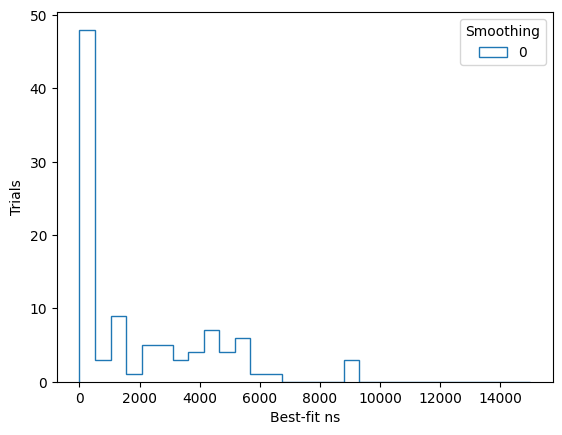

In [22]:
bins = np.linspace(0,15000, 30)
#plt.hist(trials_0['results']['ns'], bins=bins, label='0')
#plt.hist(trials_00['results']['ns'], bins=bins, histtype='step', label='0.0')
plt.hist(trials_p01['results']['ns'], bins=bins, histtype='step', label='0')
plt.legend(title="Smoothing")
plt.xlabel('Best-fit ns')
plt.ylabel('Trials')
plt.show()

# INTERNAL INSPECTION

In [ ]:
bin_chilln.minuit_result.draw_profile('ns') #min fvalue is subtracted by default

plt.show()

In [ ]:
dec_mask = (bin_chilln.bin_decs <= np.radians(bin_chilln.max_dec_deg)) & (bin_chilln.bin_decs >= np.radians(bin_chilln.min_dec_deg))

In [49]:
nss = np.linspace(-4000, 4000, 100)
tss = [bin_chilln.multinomial_TS(x, bin_chilln.counts[:,dec_mask], bin_chilln.p_s[:,dec_mask], bin_chilln.p_b[:,dec_mask], frac=bin_chilln.sig_acc_frac.reshape(25,1)) for x in nss]

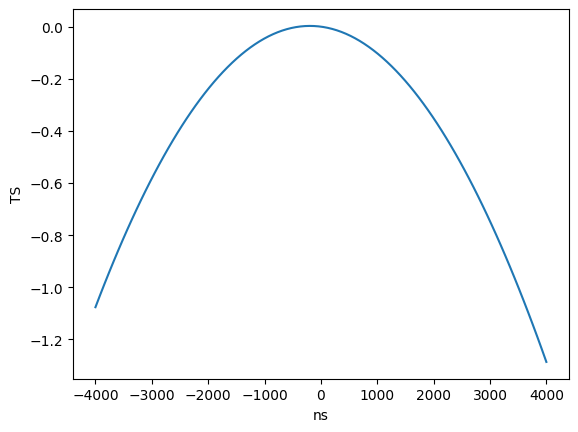

In [50]:
plt.figure(facecolor='w')
plt.plot(nss, tss)
#plt.scatter(10061559, 614638, marker='+', color='r', label='Best Fit')
plt.ylabel('TS')
plt.xlabel('ns')
#plt.legend()
#plt.loglog()
plt.show()

In [2]:
t = np.load('templates/Fermi-LAT_pi0_map.npy')

In [35]:
a = np.zeros_like(bin_chilln.counts)
for b in range(len(bin_chilln.inj_bins)):
    p,c = np.unique(bin_chilln.inj_bins[b], return_counts=True)
    p = np.array(p, dtype=int)
    a[b,p] += c

In [21]:
bin_chilln.create_bg_acc_spline(skw={'s':0})
bin_chilln.get_pdfs()

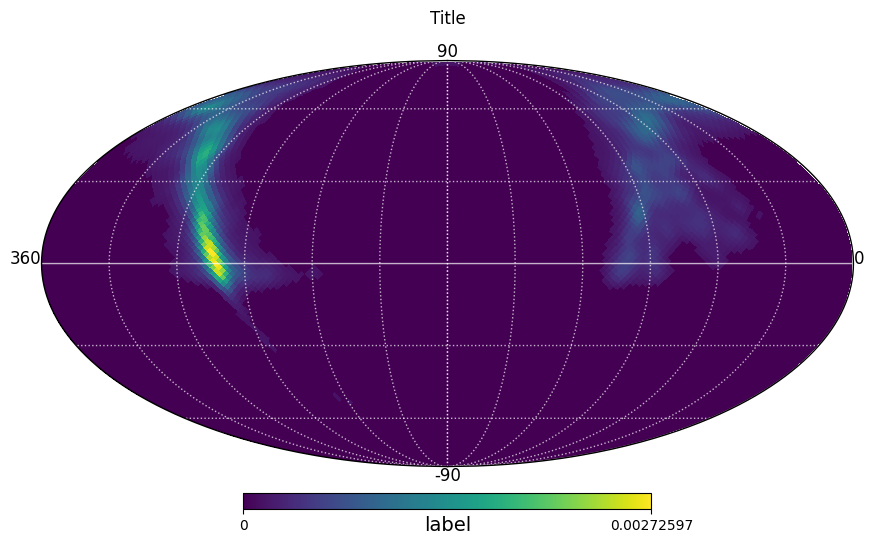

In [44]:
#plt.figure(facecolor='w')

#x = ( bin_chilln.counts - bin_chilln.p_b*np.sum(bin_chilln.counts,axis=1)[:,np.newaxis]).sum(axis=0)
#x = ( bin_chilln.binned_data - bin_chilln.p_b*np.sum(bin_chilln.binned_data,axis=1)[:,np.newaxis]).sum(axis=0)
#x = np.sum(a,axis=0)
#x = bin_chilln.get_acc_from_spline(np.sin(bin_chilln.bin_decs), 0, acc='signal')
#spl = bin_chilln.get_acc_from_spline(np.sin(bin_chilln.bin_decs), 0, acc='bg')
#x = spl/np.sum(spl[dec_mask]) / bin_chilln.p_b[0]
#a = np.load('data/level3/binned/scrambles/10yr_25bins/Fermi_pi0_10yr_25bins_level3_Scrambles.binned_scramble.seed1.nside32.npy', allow_pickle=True)
#x = a.item()['binned_scramble'][24]
x = bin_chilln.p_s[0]
#x = bin_chilln.counts[0] - bin_chilln.get_acc_from_spline(np.sin(bin_chilln.bin_decs), 0, acc='bg')*np.sum(bin_chilln.counts[0])
#x = bin_chilln.counts[0] - (bin_chilln.bg_perpix_nohist[0])
# = x / (bin_chilln.bg_perpix_nohist[0])

coord='C'
hp.mollview((x), unit=r'label', rot=(180,0,0))#, min=-1, max=1)#, cmap='RdBu_r')  #$\log_{10}($counts$)$
#for d in bin_edges:
#    hp.projplot(np.pi/2 - np.repeat(d, 500), np.linspace(0,2*np.pi,500), color='k', coord=coord, linestyle=':', linewidth=1)
hp.projtext(0,0,'90', size='large', ha='center', va='bottom', coord=coord)#, rot=rot)
hp.projtext(np.pi/2,2.0*np.pi - .001,'360', size='large', ha='right', coord=coord)#, rot=rot)
hp.projtext(np.pi/2,0,'0', size='large', ha='left', coord=coord)#, rot=rot)
hp.projtext(np.pi,0,'-90', size='large', ha='center', va='top', coord=coord)#, rot=rot)
hp.graticule(30, color='w', alpha=0.7)

plt.title('Title', pad=25)
plt.show()

In [69]:
p_b1 = bin_chilln.get_acc_from_spline(np.sin(bin_chilln.bin_decs), 0, acc='bg') 
p_b2 = bin_chilln.bg_hist[0].get_values(np.sin(bin_chilln.bin_decs))

Background acceptance spline not yet created. Creating now... 



In [75]:
asd = bin_chilln.bg_perpix_nohist[0]/hp.nside2pixarea(32)/np.sum(bin_chilln.bg_perpix_bydec_nohist[0])

In [76]:
asd

array([ 3.33611251,  3.33611251,  3.33611251, ..., 15.82159498,
       15.82159498, 15.82159498])

In [83]:
bin_chilln.sindec_bins=np.linspace(-1,1,20)

In [133]:
bin_chilln.create_signal_acc_spline(skw={'s':0})

In [44]:
bin_chilln.create_bg_acc_spline(skw={'s':0.001})

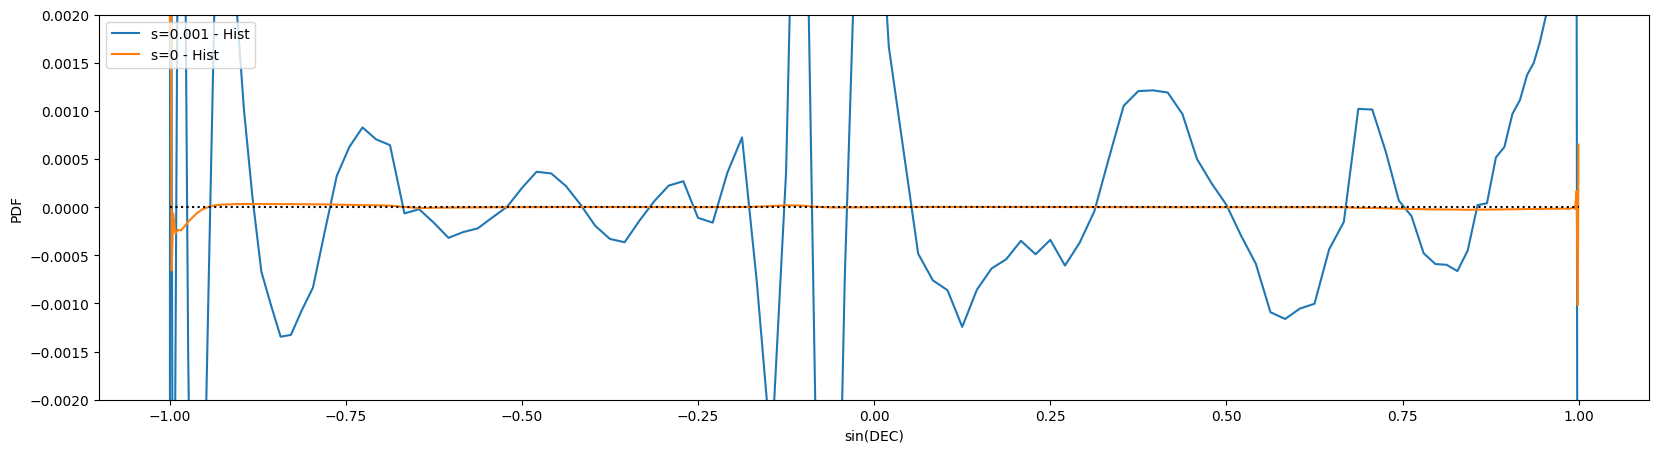

In [76]:
plt.figure(figsize=(20,5))
dec_mask = (bin_chilln.bin_decs <= np.radians(bin_chilln.max_dec_deg)) & (bin_chilln.bin_decs >= np.radians(bin_chilln.min_dec_deg))
x = (np.unique(bin_chilln.bin_decs))
y2=bin_chilln.get_acc_from_spline(np.sin(x), 0, acc='bg')
h0=bin_chilln.bg_hist[0]
#w=bin_chilln.bg_perpix_bydec_nohist[0]/hp.nside2pixarea(32)
#z=bin_chilln.p_b[0, [np.arange(hp.nside2npix(32))[bin_chilln.bin_decs==d][0] for d in x]] * np.sum(bin_chilln.get_acc_from_spline(np.sin(bin_chilln.bin_decs), 0, acc='bg')[dec_mask])
#z=bin_chilln.p_b[0, hp.ang2pix(32, np.pi/2-x, np.full_like(x, 3.131))] * np.sum(bin_chilln.get_acc_from_spline(np.sin(bin_chilln.bin_decs), 0, acc='bg')[dec_mask])

#hl.plot1d(h0, color='k', label='Hist')
#plt.plot(np.sin(x), y0, label='s=0')
#plt.plot(np.sin(x), y2, label='s=.001')
#plt.plot(np.sin(x),w, label='s=.0001')
#plt.plot(np.sin(x), y-w, label = '0 - 0.0001')
#plt.plot(np.sin(x), y-z, label = '0 - 0.001')
plt.plot(np.sin(x),y2-h0.get_values(np.sin(x)), label='s=0.001 - Hist')
plt.plot(np.sin(x),y0-h0.get_values(np.sin(x)), label='s=0 - Hist')
#plt.plot(np.sin(x),y3-h0.get_values(np.sin(x)), label='s=0.0001')
#plt.plot(np.sin(x),y2-h0.get_values(np.sin(x)), label='s=0.001')
#plt.plot(np.sin(x),y1-h0.get_values(np.sin(x)), label='s=0.01')
#plt.plot(np.sin(x),y0-h0.get_values(np.sin(x)), label='s=0')

plt.hlines(0, -1, 1, linestyle=':', color='k')
#plt.vlines(np.sin(bin_chilln.bin_decs), -.05, .25, linestyle=':', linewidth=1, color='k')

plt.xlabel('sin(DEC)')
plt.ylabel('PDF')
plt.ylim(-.002,.002)
#plt.xlim(-.2, .2)
plt.legend(title='', loc='upper left')
plt.show()

# DATA INSPECTION

In [12]:
file = 'data/level3/exp/npy/Level3_06272020_exp.npy'
data3 = np.load(file)

file = 'data/level2/exp/npy/Level2_06272020_exp.npy'
data2 = np.load(file)

file = 'data/level2_5/exp/npy/Level2_5_06272020_exp.npy'
data25 = np.load(file)

mc = np.load('data/level3/sim/npy/Level3_sim.npy')

weights = mc['oneweight'] * mc['true_energy']**(-2.7)

In [12]:
def weighted_quantile(data, weights, quantile):
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    csw = np.cumsum(weights)
    cut = np.sum(weights) * quantile
    if len(data) == 0:
        q = 0.0
    else:
        q = data[csw >= cut][0]
    return q

In [23]:
sort_q = np.sort(np.log10(data3['qtot_wdc']))
bin_event_size = int(len(sort_q) / 10)
q_bins = [sort_q[i*bin_event_size] for i in range(1,10)]
print(q_bins)
    

[1.3379581664733644, 1.4631461353451705, 1.581523960103822, 1.7411850854299111, 2.0377416512665127, 2.479511003862447, 2.8914443766681552, 3.070327584512832, 3.2164992339954814]


In [24]:
q_bins = np.array(q_bins).round(4)

array([1.338 , 1.4631, 1.5815, 1.7412, 2.0377, 2.4795, 2.8914, 3.0703,
       3.2165])

In [33]:
np.linspace(1.35,3.5,9)

array([1.35   , 1.61875, 1.8875 , 2.15625, 2.425  , 2.69375, 2.9625 ,
       3.23125, 3.5    ])

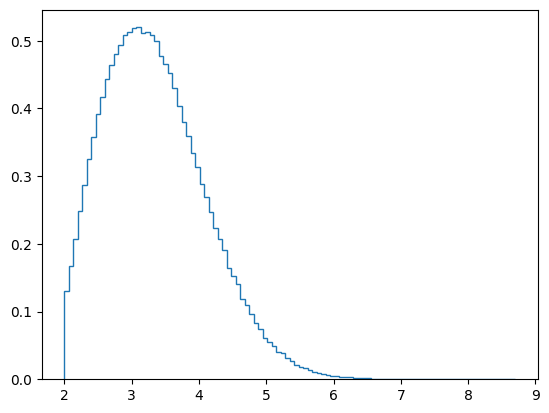

In [17]:
plt.figure(facecolor='w')
h,b,m = plt.hist(np.log10(mc['true_energy']), bins=100, histtype='step', density=True, weights=weights)
#plt.hist(np.log10(data3['qtot']), bins=b, histtype='step', label='L3', density=True)
#plt.hist(np.log10(data2['qtot']), bins=b, histtype='step', label='L2', density=True)
#plt.semilogy()
#plt.vlines(np.linspace(1.35,3.5,9), 0, 1.0, color='r', linestyle='--')
#plt.legend()
plt.show()

In [7]:
np.unique(np.digitize(np.log10(data['qtot']), np.array(q_bins).round(4)), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([25278, 18452, 19149, 19620, 20543, 20527, 21319, 22630, 21164,
        15932]))

In [81]:
25e3 * 365 * 1 / hp.nside2npix(32)

742.5944010416666

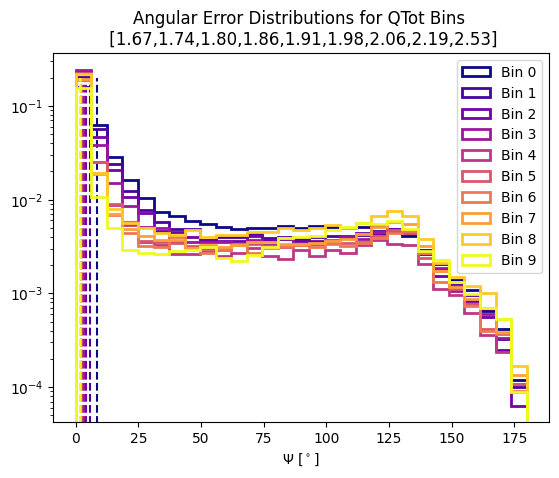

In [78]:
angErr = np.degrees(mc['true_angErr'])
ebins = np.array([1.67,1.74,1.80,1.86,1.91,1.98,2.06,2.19,2.53])
binds = np.digitize(np.log10(mc['qtot']), ebins)

bins = np.linspace(0,180,30)
plt.figure(facecolor='w')
medians = []
for i in np.unique(binds):
    mask = binds == i
    x = (angErr[mask])
    plt.hist(x, bins=bins, histtype='step', label=f'Bin {i}', color=cmap(i/np.max(binds)), linewidth=2, alpha=1, weights=weights[mask])
    plt.vlines(weighted_quantile(x, weights[mask], .5), 0, 2e-1, linestyle='--', color=cmap(i/np.max(binds)))
    medians.append(weighted_quantile(x, weights[mask], .5))
plt.semilogy()
plt.legend()
plt.xlabel(r'$\Psi$ [$^\circ$]')
plt.title('Angular Error Distributions for QTot Bins \n [1.67,1.74,1.80,1.86,1.91,1.98,2.06,2.19,2.53]')
plt.show()

In [26]:
[np.degrees(hp.nside2resol(n)) for n in [4, 8, 16, 32, 64, 128]]

[14.658075357087599,
 7.329037678543799,
 3.6645188392718997,
 1.8322594196359498,
 0.9161297098179749,
 0.45806485490898746]

In [27]:
[hp.nside2npix(n) for n in [4, 8, 16, 32, 64, 128]]

[192, 768, 3072, 12288, 49152, 196608]

In [39]:
[hp.nside2pixarea(n)*(180/np.pi)**2 for n in [4, 8, 16, 32, 64, 128]]

[214.8591731740587,
 53.714793293514674,
 13.428698323378669,
 3.357174580844667,
 0.8392936452111668,
 0.2098234113027917]

# TRIALS AND SENSITIVITY EVALUATION

In [3]:
from matplotlib import colormaps
cmap = colormaps.get_cmap('plasma')

from scipy.interpolate import interp1d, splrep, splev

In [22]:
#load and append bkg trials
pfs = {}
dists_ts = {}
dists_ns = {}
cutoff = 0.1
gamma = 2.7
level = "3"
nside = 2
where_accs = ['10yr_25bins_ARound_Smoothp001BG25Sig']
for where_acc in where_accs:

    filelist = sorted(glob(f'/data/user/mcampana/analysis/binned_tracks/trials/level{level}/{where_acc}/bkg/nside/{nside}/cutoff/{cutoff}/gamma/{gamma}/trials*.npy'))
    bg_tss = np.array([])
    bg_nss = np.array([])
    c = 0
    for f in filelist:
        c += 1
        arr = np.load(f, allow_pickle=True)
        bg_tss = np.append(bg_tss, np.array(list(arr.item()['results']))['ts'])
        bg_nss = np.append(bg_nss, np.array(list(arr.item()['results']))['ns'])
    
    bg_tss[bg_tss<0] = 0.0

    print(f'Loaded {c} files of background trials.')

    med_bg_ts = np.median(bg_tss)

    #load and append sig trials
    #nsigs = np.sort(np.array(os.listdir(f'/data/user/mcampana/analysis/binned_tracks/trials/sig/{where_acc}/nsig/'), dtype=int))
    nsigs = np.array(sorted([int(s.split('/')[-1]) for s in glob(f'/data/user/mcampana/analysis/binned_tracks/trials/level{level}/{where_acc}/sig/nside/{nside}/cutoff/{cutoff}/gamma/{gamma}/nsig/*')]))
    sig_tss = {}
    sig_nss = {}
    passing = {}
    for nsig in nsigs:
        filelist = sorted(glob(f'/data/user/mcampana/analysis/binned_tracks/trials/level{level}/{where_acc}/sig/nside/{nside}/cutoff/{cutoff}/gamma/{gamma}/nsig/{nsig}/trials*.npy'))
        tss = np.array([])
        nss = np.array([])
        c = 0
        for f in filelist:
            c += 1
            arr = np.load(f, allow_pickle=True)
            tss = np.append(tss, np.array(list(arr.item()['results']))['ts'])
            nss = np.append(nss, np.array(list(arr.item()['results']))['ns'])
        
        tss[tss<0] = 0.0

        sig_tss[nsig] = tss
        sig_nss[nsig] = nss

        #passing fractions
        passing[nsig] = np.mean(tss > med_bg_ts)
        
    sig_tss[0] = bg_tss
    sig_nss[0] = bg_nss
    
    passing[0] = .5
    
    pfs[where_acc] = passing
    dists_ts[where_acc] = sig_tss
    dists_ns[where_acc] = sig_nss

print('Done')

Loaded 100 files of background trials.
Done


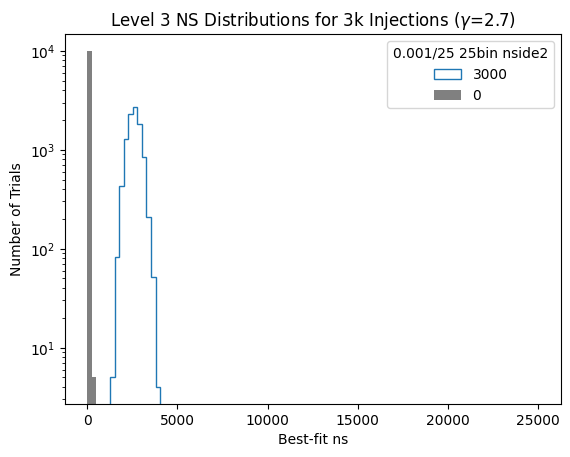

0.0006


In [23]:
plt.figure(facecolor='w')
bins = np.linspace(0, 25000, 100)
dists = dists_ns
#where_accs = ['10yr_25bins_ARound_Smooth0BG25Sig', '10yr_25bins_ARound_Smoothp001BG25Sig']
#labels = ['s=0','s=.001']
for where_acc in where_accs: 
    for nsig in [3000, 0]:#dists[where_acc].keys():#np.append(np.array([0]), nsigs):
        if nsig == 0:
            plt.hist((dists[where_acc][nsig]), label=nsig, bins=bins, color='grey')
        else:        
            plt.hist((dists[where_acc][nsig]), label=nsig, histtype='step', linewidth=1, bins=bins)#, color=cmap(nsig/np.max(nsigs)), linestyle=lss[where_accs.index(where_acc)])

    #plt.vlines(np.log10(np.median(dists_ns[where_acc][0])), 0, 1000, linestyle='--', color='k')
               
#plt.xlim(0, 600)
#plt.vlines(3000, 1, 1000, color='k')
plt.title(fr'Level {level} NS Distributions for 3k Injections ($\gamma$={gamma})')
plt.xlabel(r'Best-fit ns')
plt.ylabel('Number of Trials')
plt.legend(title=r'0.001/25 25bin nside2', loc='upper right')
plt.semilogy()
plt.show()
print(np.median(dists_ns[where_acc][0]))

In [7]:
xs = np.linspace(0,nsigs[-1],500)
ys = {}
for where_acc in where_accs:
    passing = pfs[where_acc]
    #f = interp1d(list(passing.keys()), list(passing.values()), kind='quadratic')
    #ys[where_acc] = f(xs)
    
    dkeys = sorted(list(passing.keys()))
    sorted_passing = {i: passing[i] for i in dkeys}
    splr = splrep(list(sorted_passing.keys()), list(sorted_passing.values()), k=2, s=.0001)
    ys[where_acc] = splev(xs, splr)


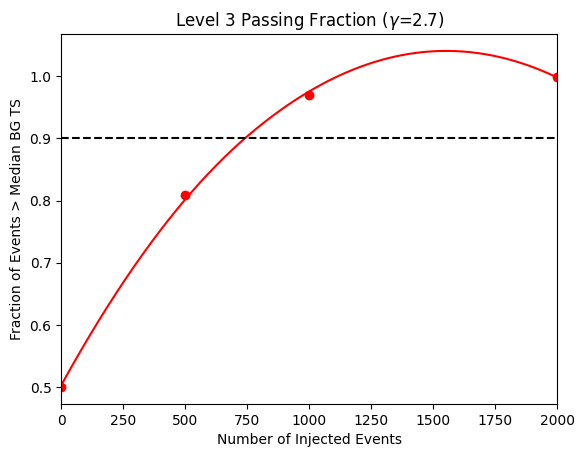

In [8]:
where_acc = where_accs[0]
passing = pfs[where_acc]
plt.scatter(sorted_passing.keys(), sorted_passing.values(), label=where_acc, color='r')
plt.plot(xs, ys[where_acc], color='r')

plt.hlines(0.9, 0, nsigs[-1], linestyle='--', color='k')
#plt.legend(title='')
plt.title(fr'Level {level} Passing Fraction ($\gamma$={gamma})')
plt.xlabel('Number of Injected Events')
plt.ylabel('Fraction of Events > Median BG TS')
plt.xlim(0,nsigs[-1])
plt.show()

In [7]:
splev(1200, splr) #

array(0.90903564)

# EXTERNAL INSPECTION

In [24]:
import json
import datetime as dt

with open('grl.txt') as f:
    data = f.read()
    
js = json.loads(data)

form = '%Y-%m-%d %H:%M:%S.%f'
#set_start = dt.datetime.fromisoformat('2012-05-15T00:00:00')
#set_stop = dt.datetime.fromisoformat('2023-01-01T05:00:00')
dur = 0.0
gruns = []
for d in js['runs']:
    if (d['good_i3'] == True) and (d['good_it'] == True):
        gruns.append(d['run'])
        start = d['good_tstart'][:26]
        stop = d['good_tstop'][:26]
        
        if len(start) < 26:
            if len(start) == 19:
                start = start + '.' + 6*'0'
            else:
                start = start + (26-len(start))*'0'
                
        if len(stop) < 26:
            if len(stop) == 19:
                stop = stop + '.' + 6*'0'
            else:
                stop = stop + (26-len(stop))*'0'
        
        dt_start = dt.datetime.strptime(start, form)
        dt_stop = dt.datetime.strptime(stop, form)
        #if dt_start < set_start:
        #    continue
        #elif dt_stop > set_stop:
        #    continue
        
        delta = dt_stop - dt_start
        
        dur += delta.total_seconds()
print('Done.')

Done.


In [8]:
gruns = np.array(gruns)

In [10]:
np.save('GRL.npy', gruns)

In [25]:
dur 
#2020 31371977.196272973
#20110514 thru 2022 359635748.7751689
#20120515 thru 2022 330055468.7751689

330055468.7751689

In [27]:
ana = cy.get_analysis(cy.selections.Repository(), 'version-003-p02', cy.selections.PSDataSpecs.IC86v3_2016)

Setting up Analysis for:
IC86v3_2016
Setting up IC86v3_2016...
Reading /data/ana/analyses/ps_tracks/version-003-p02/IC86_2012_MC.npy ...
Reading /data/ana/analyses/ps_tracks/version-003-p02/IC86_2016_exp.npy ...
Reading /data/ana/analyses/ps_tracks/version-003-p02/GRL/IC86_2016_exp.npy ...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [29]:
ana = ana[:1]
ana[0].sig = cy.utils.Arrays(np.load('data/level2/sim/npy/Level2_sim.npy', allow_pickle=True))

In [28]:
#t_repo = cy.selections.Repository(local_root='./templates')
#template = t_repo.get_template('Fermi-LAT_pi0_map')
template = np.load('templates/Fermi-LAT_pi0_map.npy', allow_pickle=True)
gamma=2.7
gp_conf = {
            'template': template,
            'flux': cy.hyp.PowerLawFlux(gamma),
            'randomize': ['ra'],
            'fitter_args': dict(gamma=gamma),
            'sigsub': False,
            'update_bg': True,
            'fast_weight': False,
        }

In [29]:
tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=1)

IC86v3_2016               | Acceptance weighting complete.                    
IC86v3_2016               | Smearing complete.                              


In [38]:
tr.to_E2dNdE(12000, E0=100, unit=1e3)

5.006380322403379e-10

In [35]:
L = tr.get_one_llh(n_sig=0, poisson=False, seed=12)

In [45]:
space = cy.inspect.get_space_eval(L,-1,0)
energy = cy.inspect.get_energy_eval(L,-1,0)

both = space(gamma=2.7)[0] * energy(gamma=2.7)[0]

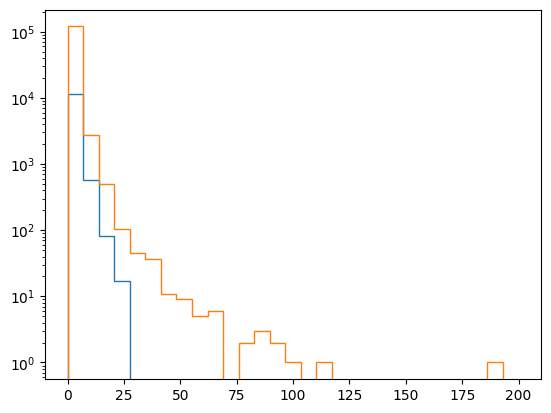

In [50]:
bins = np.linspace(0,200,30)
plt.hist(bin_chilln.p_s[31]/bin_chilln.p_b[31], bins=bins, histtype='step')
plt.hist(both, bins=bins, histtype='step')
plt.semilogy()
plt.show()

In [35]:
a3 = np.load('data/level3/sim/npy/Level3_sim.npy')
a2 = np.load('data/level2/sim/npy/Level2_sim.npy')

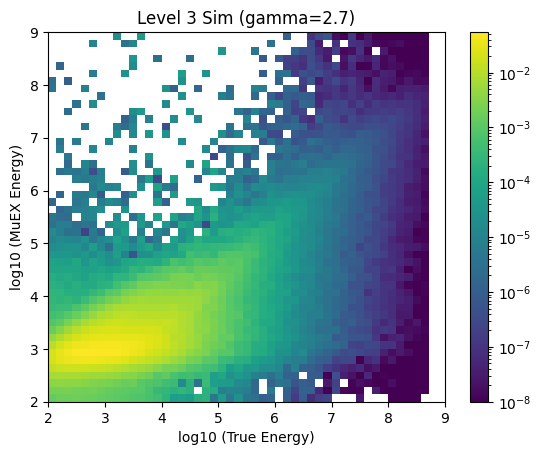

In [93]:
a = a2
weights = a['oneweight'] * a['true_energy']**(-2.7)
bins = np.linspace(2,9,50)
#bins = 50
h2d = hl.hist((np.log10(a['true_energy']), (a['logE'])), bins=(bins,bins), weights=weights)
hl.plot2d(h2d, log=True, cbar=True, vmin=1e-8)
plt.xlabel('log10 (True Energy)')
plt.ylabel('log10 (MuEX Energy)')
plt.title('Level 3 Sim (gamma=2.7)')
plt.show()

[]

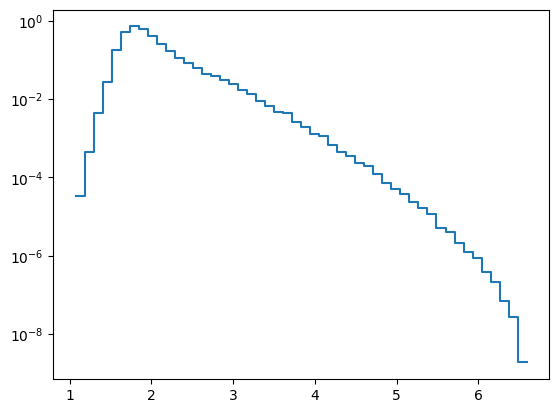

In [94]:
h1d = hl.hist(np.log10(a['qtot']), bins=50, weights=weights)
hl.plot1d(h1d)
plt.semilogy()

In [90]:
np.min(a3['qtot_wdc'])

5.324999988079071

In [63]:
ndt = np.dtype(a.dtype.descr + [('test', '<f8')])

In [76]:
b = np.empty(a.shape, dtype=ndt)

In [71]:
for n in a.dtype.names: b[n] = a[n]

In [72]:
b['test'] = np.ones_like(b['run'])

In [75]:
b['angErr'] == a['angErr']

array([ True,  True,  True, ...,  True,  True,  True])

In [83]:
b

array([(0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
       (0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
       (0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
       ...,
       (0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
       (0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.),
       (0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.)],
      dtype=[('run', '<i8'), ('event', '<i8'), ('subevent', '<i8'), ('ra', '<f8'), ('dec', '<f8'), ('azi', '<f8'), ('zen', '<f8'), ('time', '<f8'), ('logE', '<f8'), ('angErr', '<f8'), ('qtot', '<f8'), ('qtot_wdc', '<f8'), ('true_ra', '<f8'), ('true_dec', '<f8'), ('true_azi', '<f8'), ('true_zen', '<f8'), ('true_energy', '<f8'), ('true_angErr', '<f8'), ('oneweight', '<f8'), ('test', '<f8')])

In [4]:
import csky as cy

In [61]:
bg = cy.bk.get_all('/data/ana/analyses/NuSources/2021_1FLE_Blazar_Stacking/trials/bg/hemisphere/both/weight/flux/',
             'BG_*.npy', merge=np.concatenate)
sig270 = cy.bk.get_all('/data/ana/analyses/NuSources/2021_1FLE_Blazar_Stacking/trials/sig/poisson/hemisphere/both/weight/flux/gamma/2.75/nsig/270.0/',
             'SIG_*.npy', merge=np.concatenate)
sig40 = cy.bk.get_all('/data/ana/analyses/NuSources/2021_1FLE_Blazar_Stacking/trials/sig/poisson/hemisphere/both/weight/flux/gamma/2.75/nsig/40.0/',
             'SIG_*.npy', merge=np.concatenate)

/data/ana/analyses/NuSources/2021_1FLE_Blazar_Stacking/trials/bg/hemisphere/both/weight/flux/BG_1000trials_u1FLEblazars_seed100_Jun-29-2021_08-36-20.npy ...
/data/ana/analyses/NuSources/2021_1FLE_Blazar_Stacking/trials/bg/hemisphere/both/weight/flux/BG_1000trials_u1FLEblazars_seed10_Jun-29-2021_08-02-20.npy ...
/data/ana/analyses/NuSources/2021_1FLE_Blazar_Stacking/trials/bg/hemisphere/both/weight/flux/BG_1000trials_u1FLEblazars_seed11_Jun-29-2021_08-04-19.npy ...
/data/ana/analyses/NuSources/2021_1FLE_Blazar_Stacking/trials/bg/hemisphere/both/weight/flux/BG_1000trials_u1FLEblazars_seed12_Jun-29-2021_08-05-19.npy ...
/data/ana/analyses/NuSources/2021_1FLE_Blazar_Stacking/trials/bg/hemisphere/both/weight/flux/BG_1000trials_u1FLEblazars_seed13_Jun-29-2021_08-06-20.npy ...
/data/ana/analyses/NuSources/2021_1FLE_Blazar_Stacking/trials/bg/hemisphere/both/weight/flux/BG_1000trials_u1FLEblazars_seed14_Jun-29-2021_08-06-20.npy ...
/data/ana/analyses/NuSources/2021_1FLE_Blazar_Stacking/trials/b

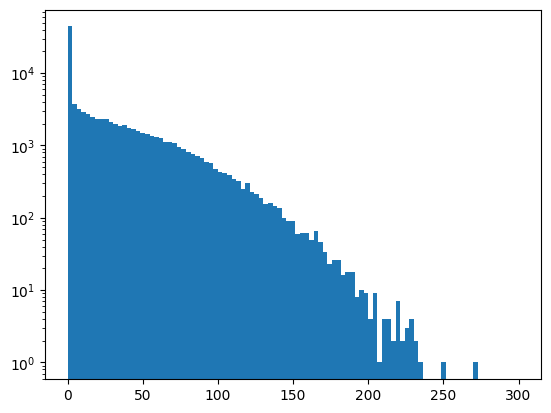

In [70]:
bins = np.linspace(0,300,100)
plt.hist((bg['ns']), bins=bins)
plt.semilogy()
plt.show()
#print(np.median(trs['ns']))

# RETIRED

In [2]:
class BinnedTemplateAllSky:
    """For conducting binned calculations using maximum likelihood statistical methods. 
    For binned sky map of IceCube event data. No separation of likelihood across declinations.
    
    
    """
    def __init__(self, data, sig, grl, is_binned=False, savedir=None, name='AllSkyBinnedTemplateAnalysis', 
                 template=None, gamma=2.7, cutoff=None, 
                 nside=128, min_dec_deg=-80, max_dec_deg=80, 
                 verbose=False):
        """BinnedTemplateAllSky constructor
        
        Args:
            data: Path to numpy array(s) (directory or single file) containing  dtype=[('run', '<i8'), 
                                                 ('event', '<i8'),
                                                 ('subevent', '<i8'),
                                                 ('ra', '<f8'),
                                                 ('dec', '<f8'),
                                                 ('azi', '<f8'),
                                                 ('zen', '<f8'),
                                                 ('time', '<f8'),
                                                 ('logE', '<f8'),
                                                 ##('angErr', '<f8')])
                                                 
                OR: Path to numpy array of binned data (in this case, set is_binned=True)
                                     
            sig: Path to numpy array containing  dtype = [('run', int), 
                                                 ('event', int), 
                                                 ('subevent', int),
                                                 ('ra', float), 
                                                 ('dec', float),
                                                 ('true_ra', float), 
                                                 ('true_dec', float),
                                                 ('azi', float), 
                                                 ('zen', float), 
                                                 ('time', float),
                                                 ('logE', float), 
                                                 ('true_angErr', float), 
                                                 ('oneweight', float),     
                                                 ('true_energy', float)]
            
            grl: Path to numpy array with GRL runs
                                     
            is_binned: boolean, True if argument data is an array of binned_data, otherwise False (data will be binned)
            
            savedir: path to directory to save binned data. Default: None (don't save)
            
            name: unique name to identify analysis (used in file names when saving)
            
            template: path to template object/array or None
                TO DO:
                    * Rescale template nside for differing energy ranges
                                                            
            gamma: spectral index for detector acceptance and injections. 
                  #This should match the one used to create
                  #the template if using one saved by csky. 
                    
            cutoff: minimum template value to be considered an On bin
                TO DO (???):
                    * Implementation without need for cutoff???

            nside: integer for healpy nside (Default: 128)
                TO DO: 
                    * Allow nside to differ for different energy ranges
                        
            min_/max_dec_deg: min and max declination in degrees for likelihood calculations.
            
            verbose: True for lots of output (Default: False)
            
            
        """
        if template is None:
            raise NotImplementedError('Current implementation can only perform template analysis!')
        elif cutoff is None:
            raise NotImplementedError('Current implementation requires a cutoff to define on/off bins!')
        
        print('Setting up:')
        
        self.name = name
        self.savedir = savedir
        ensure_dir(savedir)
        
        self.verbose = verbose
        
        self.gamma = gamma
        self.cutoff = cutoff
        self.nside = nside
        self.min_dec_deg = min_dec_deg
        self.max_dec_deg = max_dec_deg
        
        self.bin_thetas, self.bin_phis = hp.pix2ang(self.nside, np.arange(hp.nside2npix(self.nside))) 
        self.bin_ras = self.bin_phis
        self.bin_decs = np.pi/2.0 - self.bin_thetas
        
        self.grl = np.load(grl)
        
        if is_binned:
            self.binned_data = np.load(data)
            print(f'Load binned data <-- {data}')
            print(f'    Binned data loaded: Contains {len(self.binned_data)} bins with {np.sum(self.binned_data)} counts')
            if len(self.binned_data) != hp.nside2npix(self.nside):
                raise ValueError(f"Nside of loaded binned data is {hp.npix2nside(len(self.binned_data))}, but given nside is {self.nside}! You need to rebin your data.")
                
        else:
            self.load(data)
        
        self.sig_evs = np.load(sig)
        print(f'Load signal array <-- {sig}')        
        weights = self.sig_evs['oneweight'] * self.sig_evs['true_energy']**(-self.gamma)
        smooth_sig = self.weighted_quantile(self.sig_evs['true_angErr'], weights, 0.5)
        print(f'    Median true angular error: {smooth_sig}')
        
        print(f'Load template <-- {template}')
        template = np.load(template, allow_pickle=True)
        
        
        if template.dtype == 'O':
            self.template = template.item()['template']
            if len(self.template) != hp.nside2npix(self.nside):
                print(f'Template nside does not match nside argument:')
                print(f'    Template: {hp.npix2nside(len(self.template))} --> Argument: {self.nside}')
                print('Adjusting resolution of template and making smoothed PDF... \n')
                
                self.template = hp.ud_grade(self.template, self.nside)
                self.create_template_pdf(smooth_sig)
                
            else:
                sigmas = np.radians(template.item()['sigmas_deg'])
                mindex = (np.abs(sigmas-np.degrees(smooth_sig))).argmin()
                self.template_pdf = template.item()['pdf_space_sig'][mindex]            
            
        else:
            self.template = template.copy()
            
            if len(self.template) != hp.nside2npix(self.nside):
                print(f'Template nside does not match nside argument:')
                print(f'    Template: {hp.npix2nside(len(self.template))} --> Argument: {self.nside}')
                print('Adjusting resolution of template and making smoothed PDF... \n')

                self.template = hp.ud_grade(self.template, self.nside)
                self.create_template_pdf(smooth_sig)
                
            else:
                self.create_template_pdf(smooth_sig)
            
        assert self.template.shape == self.template_pdf.shape, 'Template and template PDF shapes do not match...hmmm'
        assert len(self.template) == hp.nside2npix(self.nside), 'Number of bins in template does not match provided nside?!'
        assert len(self.template) == len(self.binned_data), 'Number of bins in template does not match number of bins in binned data!'
        
        self.get_pdfs()

        print('***Setup complete!*** \n')
        
    def weighted_quantile(self, data, weights, quantile):
            ix = np.argsort(data)
            data = data[ix] # sort data
            weights = weights[ix] # sort weights
            csw = np.cumsum(weights)
            cut = np.sum(weights) * quantile
            if len(data) == 0:
                q = 0.0
            else:
                q = data[csw >= cut][0]
            return q
        
    def bin_data(self, data, verbose=None):#, truth=False, seed=None):
        """
        Convert event data into bin counts using healpy. 
        
        Args:
            data: data event array(s)
            
            verbose: True to show more output (Defaults to class's initited value)
            
        #    truth: Whether to use true event locations (True), or scramble in right ascension (False)
        #
        #    seed: integer, Seed for numpy.random.default_rng() used to scramble events (Default: None, meaning unpredictable)
        """
        
        if verbose is None:
            verbose = self.verbose
            
        event_decs = data['dec']
        event_ras = data['ra']
        #if truth:
        #    event_ras = self.data['ra']
        #else:            
        #    rng_scramble = np.random.default_rng(seed=seed)                
        #    event_ras = 2.0 * np.pi * rng_scramble.random(size=len(self.data['ra']))
        
        if verbose:
            print(f'Binning {len(event_ras)} events with nside={self.nside}...that is {hp.nside2npix(self.nside)} bins! Wow!', end=' ')
        
        event_pix_nums = hp.ang2pix(self.nside, np.pi/2.0 - event_decs, event_ras)
        
        if verbose:
            print('--> Binning Done.')

        return np.bincount(event_pix_nums)
    
    def load(self, path, verbose=None):
        """
        Loads data and bins it.
        
        Args:
            path: path to directory containing data files or path to a data file
            
            verbose: True to show more output (Defaults to class's initited value)
            
        """
        if verbose is None:
            verbose = self.verbose
        assert (os.path.isdir(path) or os.path.isfile(path)), f"Expected path to directory or file, got: {path}"
        
        print(f'Loading and binning data from {path}')
        if os.path.isdir(path):
            files_like = path+'/*.npy'
            file_list = sorted(glob(files_like))
            binned_data = np.zeros(hp.nside2npix(self.nside))
            for file in file_list:
                data = np.load(file)
                mask = np.isin(data['run'], self.grl)
                data = data[mask]
                
                if verbose:
                    print(f'    {file} | ', end=' ')
                binned_data = binned_data + self.bin_data(data)
            
            self.binned_data = binned_data
        
        else:
            data = np.load(path)
            mask = np.isin(data['run'], self.grl)
            data = data[mask]
            
            if verbose:
                print(f'    {path} | ', end=' ')
            self.binned_data = self.bin_data(data)
            
        del data
        gc.collect()
        print('--> Data Loading Done. \n')
        
        if self.savedir is not None:
            savefile = f'{self.savedir}/{self.name}.binned_data.npy'
            np.save(savefile, self.binned_data)
            print(f'Binned data saved to --> {savefile}')
            
        return
    
    def create_bg_acc_spline(self, skw={}):
        """
        Create detector acceptance spline (*background*, sinDec-dependent) for weighted product of likelihoods across declinations.
        
        Pieces taken from csky.
        
        TO DO: Is this right?
        
        Args:          
            skw: histlite.Hist.spline_fit kwargs
        
        Returns: histlite spline object
        
        """
        
        #BG pdf using only "off" pixels as defined by cutoff and within dec bounds
        #dec_mask = (self.bin_decs <= np.radians(self.max_dec_deg)) & (self.bin_decs >= np.radians(self.min_dec_deg))
        mask = (self.template_pdf <= self.cutoff)

        sindec_bins = np.unique(np.concatenate([
                             np.linspace(-1, -0.93, 4 + 1),
                             np.linspace(-0.93, -0.3, 10 + 1),
                             np.linspace(-0.3, 0.05, 9 + 1),
                             np.linspace(0.05, 1, 18 + 1) ]) )

        h_counts_nocorr = hl.hist(np.sin(self.bin_decs[mask]), weights=self.binned_data[mask], bins=sindec_bins)

        #binds = np.digitize(np.sin(self.bin_decs), sindec_bins)
        #bs = np.array([np.sum(mask & (binds==ind)) for ind in range(1, len(sindec_bins))])
        
        bin_edges = np.arcsin(sindec_bins)
        dOmega_corr = []
        for i in np.arange(len(bin_edges)-1):
            pixels_in_band = hp.query_strip(self.nside, np.pi/2-bin_edges[i+1], np.pi/2-bin_edges[i])
            bool_array = np.isin(pixels_in_band, np.arange(hp.nside2npix(self.nside))[~mask])
            number_true = np.count_nonzero(bool_array)
            corr = float(len(pixels_in_band)/float((len(pixels_in_band)-number_true)))
            dOmega_corr.append(corr)
        
        counts_corr = h_counts_nocorr.values * np.array(dOmega_corr)
        
        h_counts = hl.Hist(values=counts_corr, bins=sindec_bins)
        
        h = h_counts.normalize(density=True) / (2*np.pi)

        skw = {}
        skw.setdefault('s', 0)
        skw.setdefault('k', 2)
        skw.setdefault('log', True)
        s_hl = h.spline_fit(**skw)
        
        self.bg_acc_spline = s_hl.spline
        
        return self.bg_acc_spline
    
    def create_signal_acc_spline(self, skw={}):
        """
        Create detector acceptance spline (*signal*, sinDec-dependent) for weighted product of likelihoods across declinations.
        
        Pieces taken from csky.
        
        TO DO: Is this right? Spline could use some work.
        
        Args:
            skw: histlite.Hist.spline_fit kwargs (Unused.)
        
        Returns: scipy spline object
        
        """
        
        '''
        xs = np.r_[self.bin_decs[0], self.bin_decs, self.bin_decs[-1]]
        ws = np.r_[(self.template_pdf)[0], self.template_pdf, (self.template_pdf)[-1]]
        h_counts = hl.hist(xs, weights=ws, bins=30)   #Evaluate accuracy of this spline especially at poles
        h = h_counts.normalize(density=True) / (2*np.pi)
        hrange = h.range[0]
        
        skw.setdefault('s', 0)
        skw.setdefault('k', 2)
        skw.setdefault('log', True)
        s_hl = h.spline_fit(**skw)
        
        self.signal_acc_spline = s_hl.spline
        '''
        
        print('Using csky to obtain acceptance spline...')
        a = cy.utils.Arrays(init=self.sig_evs, convert=True)
        spl = cy.pdf.SinDecAccParameterization(a).s
        print('--> Acceptance Spline Done.')
        
        self.signal_acc_spline = spl

        return self.signal_acc_spline
    
    def get_acc_from_spline(self, sindec, acc='signal'):
        """
        Used spline to get acceptance at a give sin(Dec).
        
        Args:
            sindec: Sine of declination(s)
            
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'signal')
            
        Returns: acceptance(s) for provided sin(Dec).
        
        """
        
        if acc == 'signal':
            try:
                out = np.exp(self.signal_acc_spline.ev(self.gamma, sindec))
            except AttributeError:
                print('Signal acceptance spline not yet created. Creating now... \n')
                self.create_signal_acc_spline()
                out = np.exp(self.signal_acc_spline.ev(self.gamma, sindec))
                
            return out
                
        elif acc == 'bg':
            try:
                out = np.exp(self.bg_acc_spline(sindec))
            except AttributeError:
                print('Background acceptance spline not yet created. Creating now... \n')
                self.create_bg_acc_spline()
                out = np.exp(self.bg_acc_spline(sindec))
                
            return out
        
        else:
            raise NotImplementedError('Argument spline must be one of ["signal", "bg"].')
            
    def create_template_pdf(self, smooth_sig):
        """
        Applies detector acceptance to template and smooths, normalizes.
        
        Args:
            smooth_sig: Sigma (in radians) for gaussian smoothing using healpy.smoothing(x, sigma=smooth_sig)

        """
        
        print("Applying detector acceptance to template...")
        #Make acceptance spline
        self.create_signal_acc_spline()
        #Apply spline
        template_acc = self.template * self.get_acc_from_spline(np.sin(self.bin_decs), acc='signal') 
      
        template = self.template.copy()

        def smooth(temp, smooth_sig):
            temp_pdf = temp / (np.sum(temp))
            mask = (self.template > 0) & (temp_pdf <= 0)
            temp_pdf[mask] = hp.UNSEEN
            
            #Smooth
            #template_pdf = self.template.copy()
            temp_pdf = hp.smoothing(temp_pdf, sigma=smooth_sig)
            #Reset nonsensical values 
            temp_pdf[mask] = 0
            temp_pdf[temp_pdf < 1e-12] = 1e-12
            dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))
            #Re-normalize
            temp_pdf = temp_pdf / ( np.sum(temp_pdf[dec_mask]) * hp.nside2pixarea(self.nside) )
            
            return temp_pdf
        
        self.template_smoothed = smooth(template, smooth_sig)
        self.template_acc_smoothed = smooth(template_acc, smooth_sig)
        
        #This, self.template_pdf, is what gets used in defining N_on and N_off.
        #The above, self.template_acc_smoothed, will always be used for injections. 
        self.template_pdf = self.template_acc_smoothed

        print('--> Template PDF Done. \n')
        
        return

    def multinomial_TS(self, n_sig, n, p_s, p_b):
        """
        This function is used to calculate the multinomial TS:
        TS = 2 \sum_i n_i \ln\left( \frac{n_s}{N}\left(\frac{s_i}{b_i} - 1\right) + 1 \right)
        
        It is minimized for n_sig in the fitting functions.
        
        Args:
            n_sig: number of (signal) events
            
            n: array of event counts in pixels (via healpy)
            
            p_s: array of pixel-wise signal probabilities using signal/template PDf
            
            p_b: array of pixel-wise background probabilities using background PDF
            
        Returns: TS as calculated in the above equation.
        
        """
                
        TS = 2.0 * np.sum( n * np.log( (n_sig / np.sum(n)) * (p_s / p_b - 1.0) + 1.0 ) )
        
        return TS
    
#    def poisson_TS(self, n_sig, n, p_s, p_b):
#        """
#        This function is used to calculate the poisson TS.
#        
#        It is minimized for n_sig in the fitting functions.
#        
#        Args:
#            n_sig: number of (signal) events
#            
#            n: array of event counts in pixels (via healpy)
#            
#            p_s: array of pixel-wise signal probabilities using signal/template PDf
#            
#            p_b: array of pixel-wise background probabilities using background PDF
#            
#        Returns: TS as calculated in the above equation.
#        
#        """
#                
#        TS = 2.0 * np.sum( (n_sig / np.sum(n)) * (p_b - p_s) + n * np.log( (n_sig / np.sum(n)) * (p_s / p_b - 1.0) + 1.0 ) )
#        
#       return TS
    
    def get_pdfs(self, verbose=None):
        """
        Creates signal and background pdfs used in the test statistic calculation/minimization.
        
        `p_s` is the signal PDF; i.e., the template_pdf with pixels that do not pass the cutoff set to 0 and renormalized within dec bounds
        
        `p_b` is the background PDF; i.e., using the bg spline of 'off' bin counts and renormalized within dec bounds
        
        
        """
        if verbose is None:
            verbose = self.verbose
        
        if verbose:
            print('Creating signal and background PDFs for TS calculations...')
        
        mask = (self.template_pdf > self.cutoff)
        dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))
        
        p_s = self.template_pdf.copy()
        
        #Any pixels that do not pass the cutoff are set to 0 signal probability
        p_s[~mask] = 0.0
        p_s /= np.sum(p_s[dec_mask]) * hp.nside2pixarea(self.nside)
        
        p_b = self.get_acc_from_spline(np.sin(self.bin_decs), acc='bg')
        p_b /= np.sum(p_b[dec_mask]) * hp.nside2pixarea(self.nside)
        
        #ReNormalize (is this right?)  
        sum_p = np.sum(p_s[dec_mask] + p_b[dec_mask])
        p_s /= sum_p
        p_b /= sum_p
        
        self.p_s = p_s
        self.p_b = p_b
        
        if verbose:
            print('--> PDFs Done.')
            
        return
    
    def get_one_fit(self, n_sig=0, truth=False, seed=None, verbose=None):
        """
        Obtains a single all-sky likelihood ratio.
        
        Args:
            n_sig: number of (signal) events to inject (Default: 0). Only used if truth=False
                    
            truth: Whether to use true event locations (True), or scramble in right ascension (False)
        
            seed: integer, Seed for numpy.random.default_rng() used to scramble events and pick injection locations
                  (Default: None, meaning unpredictable)
                  
            verbose: True to show more output (Defaults to class's initited value)
            
        Returns: dictionary containing all-sky llr, sinDec llrs, and sinDec acceptances
        
        """
        if verbose is None:
            verbose = self.verbose
        
        if truth:
            self.counts = self.binned_data.copy()

        else:
            self.counts = self.scrambler(seed=seed)                
            if n_sig != 0:
                self.template_injector(n_sig=n_sig, seed=seed)
                
        dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))

        n = self.counts[dec_mask].copy()
        p_s = self.p_s[dec_mask].copy()
        p_b = self.p_b[dec_mask].copy()
        
        #Then, minimize...
        def min_neg_TS(ns):
            return -1.0 * self.multinomial_TS(ns, n, p_s, p_b)
        
        if verbose:
            print('Minimizing -TS...')
        res = iminuit.minimize(min_neg_TS, 1, bounds=[(0,np.sum(n))])
        #res = sp.optimize.minimize(min_neg_TS, 1, bounds=[(0,np.sum(n))])
        
        fit_ns = res.x
        fit_TS = -1.0 * res.minuit.fval
        #fit_TS = -1.0 * res.fun
        
        result = np.array([(seed, fit_ns, fit_TS)], dtype=[('seed', int),('ns', float),('ts', float)])
        
        if verbose:
            print(f' --> One All Sky Fit Done: ns={fit_ns}, TS={fit_TS}')
            
        print(res)
        return result
    
    def get_many_fits(self, num, n_sig=0, seed=None, verbose=None):
        """
        Obtains multiple best-fit ns and TS.
        
        Args:
            num: integer, number of llrs to compute
            
            n_sig: number of (signal) events to inject (Default: 0)
                                    
            seed: integer, seed used to create multiple new seeds for scrambles (Default: None, unpredictable)
            
            verbose: True to show more output (Defaults to class's initited value)
            
        Returns: dictionary with {'n_sig': n_sig, 'results': structured array of (seed, ns, ts) }
        
        """
        print(f'Calculating {num} TS with {n_sig} injected event(s)...')
        if verbose is None:
            verbose = self.verbose
            
        results = np.array([],dtype=[('seed', int),('ns', float),('ts', float)])
        
        num = int(num)
        if num < 1:
            raise ValueError(f'num must be a positive integer, got: {num}')
        elif num == 1:
            results = np.append(results, self.get_one_fit(n_sig=n_sig, seed=seed, acc=acc, verbose=verbose))
        else:
            rng_seed = np.random.default_rng(seed)
            for i in range(1, num+1):
                new_seed = rng_seed.integers(int(1e9))

                results = np.append(results, self.get_one_fit(n_sig=n_sig, seed=new_seed, verbose=verbose))
                    
        res_dict = {'n_inj': n_sig, 'results': results}
        
        print(f'--> {num} Fits Done!')
        
        return res_dict        
         
    def fit_TS_chi2(self, tss):
        """
        Fit distribution of TSs > 0 with a chi-squared funtion.
        
        Args:
            tss: array of TSs
        
        Returns: Chi2 degrees of freedom, location, scale parameters
        
        """
        self.eta = np.mean(tss>0)
        self.df, self.loc, self.scale = sp.stats.chi2.fit(tss[tss>0], 1)     # 1 indicates starting guess for chi2 degrees of freedom
        self.chi2_fit = sp.stats.chi2(self.df, self.loc, self.scale)
        
        print('Chi2 distribution fit to TS > 0 with:')
        print(f'    DoF: {self.df}')
        print(f'    loc: {self.loc}')
        print(f'    scale: {self.scale}')
        print(f'    eta: {self.eta}')
        
        return 
    
    def TS_to_p(self, ts, bg=None, use='fit', dof=1):
        """
        Converts given TS to p-value using chosen method.
        
        Args:
            ts: float or array of floats, TS to convert to p-value
            
            bg: None or array, background TSs (Default: None)
            
            use: string, which method/distribution to use.
                 One of 'fit', 'chi2_dof', or 'hist'. If 'fit' and argument bg is not None, will fit a Chi2 distribution to\
                 the provided bg distribution. If 'chi2_dof', will use a Chi2 with provided dof and loc=0, scale=1. If \
                 'hist', will use the bg TSs themselves. (Default: 'fit')
                 
            dof: Number of degrees of freedom to use if use='chi2_ndof'
            
        Returns: p-value(s)
                 
        """
        if use not in ['fit', 'chi2_dof', 'hist']:
            raise ValueError(f'Argument use must be one of "fit", "chi2_dof", or "hist", got "{use}"')
            
        if (use == 'chi2_ndof') or (bg is None):
            #TS --> p using generic Chi2 function
            #Necessary if no BG distribution is provided
            
            print(f'Calculating p-value(s) using a Chi2 Distribution with {dof} degrees of freedom...')
            p = sp.stats.chi2.sf(ts, df=dof)
            print(f'    p = {p}')
            
        elif use == 'fit':
            #TS --> p using Chi2 fit
            #Requires BG dist to be provided
            
            print(f'Calculating p-value(s) using a Chi2 Distribution fit to provided background...')
            self.fit_TS_chi2(bg)
            p = self.chi2_fit.sf(ts)
            print(f'    p = {p}')
            
        elif use == 'hist':
            #TS --> p using distribution directly
            #Requires BG dist to be provided
            
            print(f'Calculating p-value(s) using background TSs distribution directly...')
            p = np.array([np.mean(bg >= t) for t in ts])
            print(f'    p = {p}')
            
        return p
    
    def create_bin_count_spline(self):
        """
        Creates a 2d spline of bin counts vs bin sin(dec) for use in creating scrambles with self.scrambler
        
        """
        #Use only "off" pixels for generating "scrambled" pixels
        mask = (self.template_pdf <= self.cutoff)
        
        sindec_bins = np.unique(np.concatenate([
                     np.linspace(-1, -0.93, 4 + 1),
                     np.linspace(-0.93, -0.3, 10 + 1),
                     np.linspace(-0.3, 0.05, 9 + 1),
                     np.linspace(0.05, 1, 18 + 1) ]) )
        count_bins = np.linspace(0, np.quantile(self.binned_data, 0.99), 100)
        h = hl.hist((self.binned_data[mask], np.sin(self.bin_decs[mask])), 
                    bins = (count_bins, sindec_bins))

        skw = {}
        skw.setdefault('s', 0)
        skw.setdefault('kx', 2)
        skw.setdefault('ky', 2)
        s_hl = h.spline_fit(**skw)
        
        self.bin_count_spline = s_hl.spline
        
        return
    
    def scrambler(self, seed=None, verbose=None):
        """
        Gets a map of "scrambled" counts by sampling from self.bin_count_spline with given sindec
        
        Args:       
            seed: integer, Seed for numpy.random.default_rng() used to scramble events and pick injection locations
                  (Default: None, meaning unpredictable)
        
        """
        if verbose is None:
            verbose = self.verbose
        
        if verbose:
            print(f'Creating random scramble with seed {seed}...')
            
        if not hasattr(self, 'bin_count_spline'):
            self.create_bin_count_spline()
        
        unique_decs = np.unique(self.bin_decs)
        
        rng_scramble = np.random.default_rng(seed=seed)
        counts = np.zeros_like(self.binned_data)
        for dec in unique_decs:
            mask = (self.bin_decs == dec)
            crange = np.arange(np.quantile(self.binned_data[mask], 0.1), np.quantile(self.binned_data[mask], 0.9)+1, 1)
            weights = np.clip(self.bin_count_spline.ev(crange, np.sin(dec)), a_min=1e-12, a_max=None)
            counts[mask] = rng_scramble.choice(crange, size=np.sum(mask), p=weights/np.sum(weights))
            
        #Adjust so sum(counts) ~= sum(binned_data)
        counts = np.around(counts * np.sum(self.binned_data) / np.sum(counts))
        
        if verbose:
            print(f'--> Scrambling Done. Scramble contains {np.sum(counts)} total counts.')
            
        return counts            
    
    def template_injector(self, n_sig, seed=None, verbose=None):
        """
        Injects events based on template probabilities.
        
        Args:
            n_sig: number of events to inject (with poisson fluctuations)
            
            seed: integer, Seed for numpy.random.default_rng() used to pick injection locations (Default: None, meaning unpredictable)
            
        """
        #NOTE: energy not yet implemented. Gamma is unused here!
        if verbose is None:
            verbose = self.verbose
                           
        rng_inj = np.random.default_rng(seed=seed)
        poisson_n_sig = rng_inj.poisson(lam=n_sig)
        
        #Injection bins are choice of ON bins (defined by self.template_pdf > self.cutoff) within dec bounds
        #The probability of choice within the ON bins is always including the acceptance, whether template_pdf does or not. 
        mask = (self.template_pdf > self.cutoff)
        dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))
        
        if verbose:
            print(f'Injecting {n_sig} events in "On" bins according to template+acceptance probabilities with poisson fluctuation ({poisson_n_sig})...')
        
        inj_choice = np.arange(hp.nside2npix(self.nside))[mask & dec_mask]
        inj_probs = self.template_acc_smoothed[mask & dec_mask] / np.sum(self.template_acc_smoothed[mask & dec_mask])
        self.inj_bins = rng_inj.choice(inj_choice, size=poisson_n_sig, p=inj_probs)

        
        #Get unique injection bins and times to inject in each bin
        bin_nums, bin_injs = np.unique(self.inj_bins, return_counts=True)
        
        #Add injections to counts in respective bins
        self.counts[bin_nums] += bin_injs
        
        if verbose:
            print('--> Injections Done.')
                
        return          
        